In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.signal import resample
from scipy.ndimage import gaussian_filter
import cv2
from tqdm.notebook import tqdm

import deepinvhessian.fwi as fwi
from deepinvhessian.utilities import *
from deepinvhessian.filters import *
from deepinvhessian.train import *
from deepinvhessian.masks import *
from unet import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
set_seed(14)

# https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Prepare data

In [3]:
# Velocity model
inputvolve = np.load('../data/Velocities.npz')
velback = inputvolve["vback"]
print(velback.shape)
x = inputvolve["x"]
z = inputvolve["z"]
r = inputvolve["recs"].T

(900, 1290)


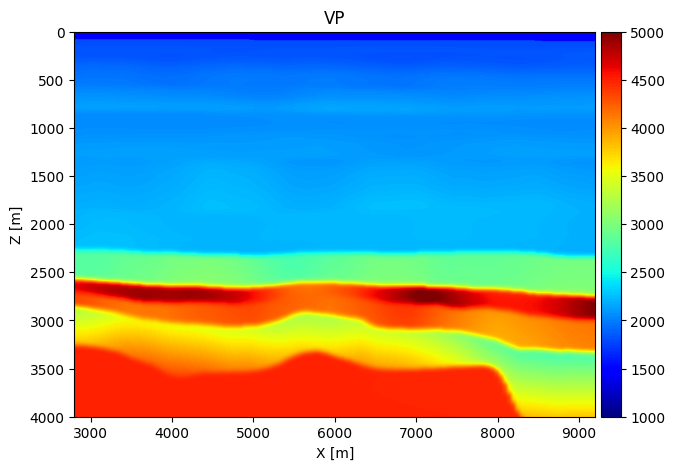

In [4]:
show_model(torch.tensor(velback), cmap='jet', vmin=1000, vmax=5000, figsize=(8, 5), extent=(x[0], x[-1], z[-1], z[0]),
           title='VP', xlim=(2800, 9200), ylim=(4000, 0),)

In [5]:
# Remove water layer and create the initial model by smoothing the velocity model velback
velback_no_water = np.copy(velback)
velback_no_water[velback_no_water==1480] = 1800
model_init = gaussian_filter(velback_no_water, sigma=60)
model_init = cv2.resize(model_init, (516, 360))
model_init = torch.tensor(model_init)

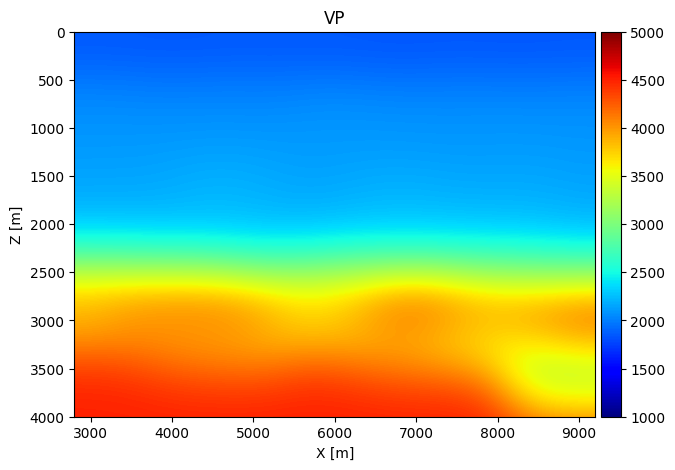

In [6]:
show_model(model_init, cmap='jet', vmin=1000, vmax=5000, figsize=(8, 5), extent=(x[0], x[-1], z[-1], z[0]),
           title='VP', xlim=(2800, 9200), ylim=(4000, 0),)

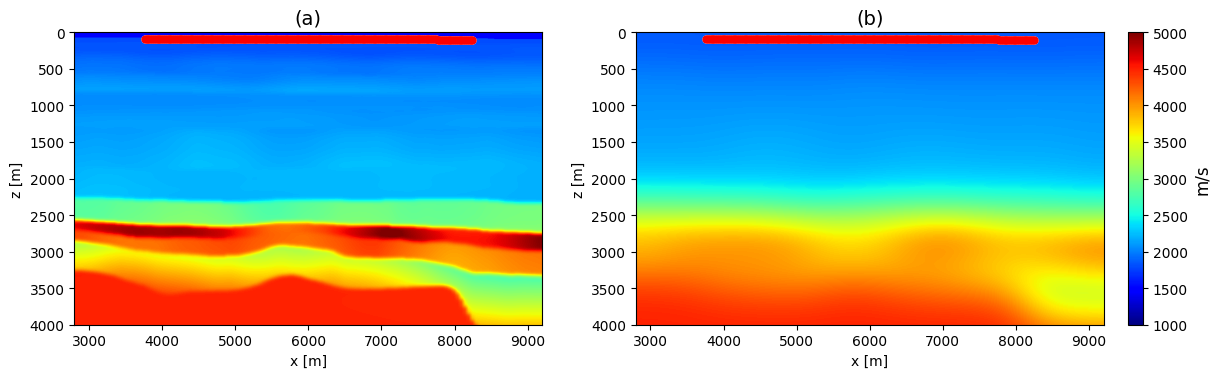

In [7]:
j = 1
fig, axes = plt.subplots(1, 2, figsize=(16, 10))
im1 = axes[0].imshow(velback, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axes[0].plot(r[0][::j], r[1][::j], '.w', ms=10)
axes[0].plot(r[0][::j], r[1][::j], '.r', ms=10)
axes[0].set_xlabel(r'x [m]')
axes[0].set_ylabel(r'z [m]')
axes[0].set_title(r'(a)', fontsize=14)
axes[0].set_xlim(2800, 9200)
axes[0].set_ylim(4000, 0)

im2 = axes[1].imshow(model_init, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
axes[1].plot(r[0][::j], r[1][::j], '.w', ms=10)
axes[1].plot(r[0][::j], r[1][::j], '.r', ms=10)
axes[1].set_xlabel(r'x [m]')
axes[1].set_ylabel(r'z [m]')
axes[1].set_title(r'(b)', fontsize=14)
axes[1].set_xlim(2800, 9200)
axes[1].set_ylim(4000, 0)
fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.38, pad=0.02).set_label(label='m/s',size=12)

In [8]:
# MDD data
fmdd = np.load('../data/mdd_volvereal_multimasked_iter40_batch32_all.npz')

t = fmdd['t']
rmdd = fmdd['Rnsgd']
# Resample data
print(rmdd.shape)
rmdd = resample(rmdd, len(rmdd[:, 10, 10])*2)
print(rmdd.shape)
t = resample(t, len(t)*2)
print(t.shape)

(2000, 180, 180)
(4000, 180, 180)
(4000,)


In [9]:
par = {
        # model parameters
        'nx':516,   'dx':12.5,  'ox':0,
        'nz':360,   'dz':12.5,  'oz':0,
        'nr':180,   'dr':torch.tensor(r[0]),  'orec':0,  'rz':torch.tensor(r[1]),
        'num_shots':180,   'ds':torch.tensor(r[0]),  'os':0,  'sz':torch.tensor(r[1]),
        'nt':4000,  'dt':0.001,  'ot':500,
        'num_sources_per_shot': 1, 'num_receivers_per_shot': 180,
        'num_dims':2,
        'num_batches':180,
        'freq': 4,
        'dt': 0.001
}
wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_4Hz.npz')['wav']
time_shift = wavelet.argmax()
print(time_shift)
params = fwi.FWIParams(par,0.0002*torch.tensor(wavelet), 'volve')

499


## Run FWI with the Barzilai-Borwein method

In [10]:
exp_name = 'Exp_Volve_BB'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

  0%|          | 0/60 [00:00<?, ?it/s]

FWI iteration: 0 loss = 9.686514165523691e-14
FWI iteration: 1 loss = 9.089564221228844e-14
 alpha = 115.48757934570312
FWI iteration: 2 loss = 8.858893577705724e-14
 alpha = 224.7806396484375
FWI iteration: 3 loss = 8.582461694980578e-14
 alpha = 279.3551330566406
FWI iteration: 4 loss = 8.38490412740513e-14
 alpha = 103.75049591064453
FWI iteration: 5 loss = 8.306217576872295e-14
 alpha = 65.24653625488281
FWI iteration: 6 loss = 8.261559967013975e-14
 alpha = 68.7078857421875
FWI iteration: 7 loss = 8.225541302653565e-14
 alpha = 694.1950073242188
FWI iteration: 8 loss = 7.920530283589651e-14
 alpha = 726.8092651367188
FWI iteration: 9 loss = 7.757497805296424e-14
 alpha = 79.9921646118164
FWI iteration: 10 loss = 7.6944366729472e-14
 alpha = 71.04595947265625
FWI iteration: 11 loss = 7.676323965101522e-14
 alpha = 54.52680587768555
FWI iteration: 12 loss = 7.664175752691661e-14
 alpha = 75.95578002929688
FWI iteration: 13 loss = 7.648045681689552e-14
 alpha = 378.87237548828125
FWI

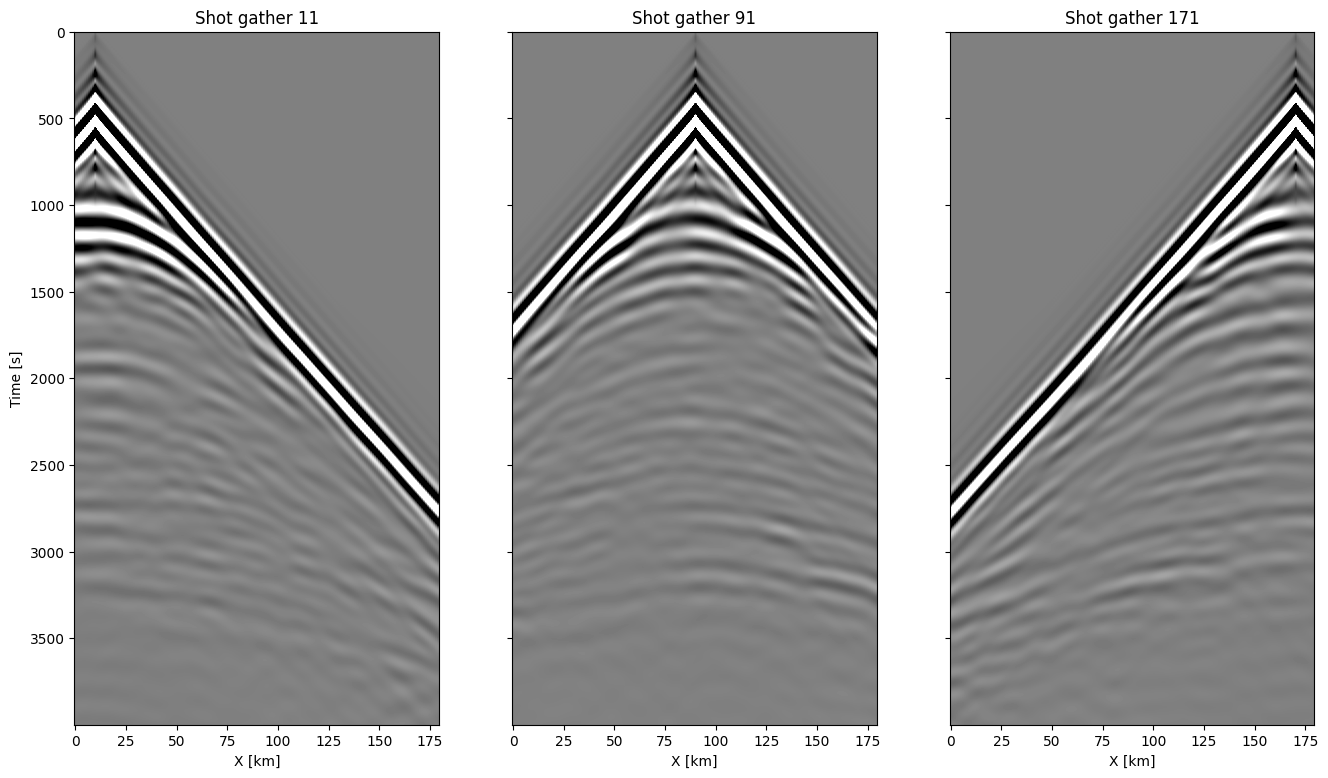

FWI iteration: 59 loss = 1.8349330971527256e-11
 alpha = 68.12764739990234
Runtime:0:25:25.047762


In [11]:
# Run conventional FWI with the Barzilai-Borwein method for a maximum frequency of [4, 7, 10] Hz

# Move model to GPU if using GPU
model = model_init.clone().to(device)
model.requires_grad = True
# Create lists to save results
gradients, updates, fwi_loss, alphas = [], [], [], []

# Create mask for the shallow part of the gradient
mask = torch.ones_like(model)
mask[:25] = 0
# Create a taper for the gradient
taper = cosine_taper(nz=par['nz'], nx=par['nx'], top_width=100, bottom_width=150)
taper = torch.tensor(taper).to(device)
# Create a mask for the direct arrivals
masks_d = params.create_masks(window_size = 600, v_direct = 1800, ot=1000)
masks_d = torch.tensor(masks_d).float().to(device)

loss_fn = nn.MSELoss()  # Misfit function for FWI
optimizer = torch.optim.SGD([{'params': [model], 'lr': 1e2}])  # Optimizer to run FWI with step size: lr
alphas.append(1e2)
tsamples = 499 # Number of time samples starting from zero to exclude from computing the misfit or shift the data
wav_scaling = 0.0002 # Source wavelet scaling
sigmah, sigmav = 4*2, 10*2 # smoothing parameter for the gradient in the horizontal and vertical direction, respectively
FWI_iter = 60 # Total number of FWI iterations
iterations = [0, 20, 40] # Starting iteration for each frequency, [4, 7, 10] Hz, respectively

t_start = time.time()
for iteration in tqdm(range(FWI_iter)):
    # Get the wavelet and the process the data according to the frequency
    if iteration == iterations[0]: # 4 Hz
        wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_4Hz.npz')['wav']
        params = fwi.FWIParams(par, wav_scaling*torch.tensor(wavelet), 'volve')
        observed_data = fwi.process_data(params, rmdd, pd=20, fn=4, time_shift=time_shift, window_size = 600, v_direct = 1800, more_near_offset_mute=None).to(device)

    elif iteration == iterations[1]: # 7 Hz
        wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_7Hz.npz')['wav']
        params = fwi.FWIParams(par,wav_scaling*torch.tensor(wavelet), 'volve')
        observed_data = fwi.process_data(params, rmdd, pd=20, fn=7, time_shift=time_shift, window_size = 600, v_direct = 1800, more_near_offset_mute=None).to(device)
        sigmah /= 2
        sigmav /= 2

    elif iteration == iterations[2]: # 10 Hz
        wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_10Hz.npz')['wav']
        params = fwi.FWIParams(par,wav_scaling*torch.tensor(wavelet), 'volve')
        observed_data = fwi.process_data(params, rmdd, pd=20, fn=10, time_shift=time_shift, window_size = 600, v_direct = 1800, more_near_offset_mute=None).to(device)
    # Save simulated data
    if iteration == FWI_iter - 1:
        data = fwi.forward_modelling(params, model.detach().clone(), device).cpu().numpy()
        show_3_shots(-1*data, [10, 90, 170], clip=0.02, save_path=f'{exp_name}/simulated_data_iter_{iteration}_freq_10_final.png')
        np.savez(f'{exp_name}/simulated_data_iter_{iteration}_freq_10_grad_final', data=data)
    # Compute FWI gradient
    optimizer.zero_grad()
    grad, iter_loss = fwi.compute_gradient(params, model, -observed_data, loss_fn, tsamples, device, masks_d)
    fwi_loss.append(iter_loss)
    print(f'FWI iteration: {iteration} loss = {fwi_loss[-1]}')
    # Clip the gradient values
    torch.nn.utils.clip_grad_value_(model, torch.quantile(grad.detach().abs(), 0.98))
    # Smooth the gradient
    grad[:] = apply_1d_gaussian_filter(grad.detach(), sigmah, sigmav)
    # Get the maximum of the gradient
    if iteration == iterations[0]: 
        gmax0 =  torch.abs(grad.detach()).max()
    elif iteration == iterations[1]:
        gmax0 =  torch.abs(grad.detach()).max()
    elif iteration == iterations[2]:
        gmax0 =  torch.abs(grad.detach()).max()
    # Normalize the gradient, mask it around the sources and apply tapering to the shallower and deeper parts
    grad = (grad /gmax0) * mask * taper
    gradients.append(grad.cpu().detach().numpy())
    # Calculate the step size
    if iteration > 0:
        delta_model = model.detach().clone() - previous_model
        delta_grad = grad.detach().clone() - previous_grad
        alpha = fwi.bb_step(delta_model, delta_grad, 'short')
        alphas.append(alpha)
        print(f' alpha = {alpha}' )
        optimizer.param_groups[-1]['lr'] = alpha
    # Save the current solution and gradient for calculating the step size in the next iteration
    previous_model = model.detach().clone()
    previous_grad = grad.detach().clone()
    # Update the model
    model.grad.data[:] = grad
    optimizer.step()
    updates.append(model.detach().clone().cpu().numpy())
    # Plot the results
    # show_one_iter_fwi(grad.cpu(), model.detach().cpu(), iteration=iteration,
    #             cmap='bwr', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]),
    #             xlim = (2800, 9200), ylim = (4000, 0), save_path=f'{exp_name}')
t_end = time.time()
t_delta = t_end - t_start
print(f'Runtime:{datetime.timedelta(seconds=t_delta)}')
# Save the results
np.savez(f'{exp_name}/losses', fwi_loss=np.array(fwi_loss), alphas=np.array(alphas))
np.savez(f'{exp_name}/gradient', updates=np.array(updates), gradients=np.array(gradients) )

In [12]:
torch.cuda.empty_cache()
gc.collect()

9774

In [13]:
loss = np.array(fwi_loss)
loss[:20] /= loss[0]
loss[20:40] /= loss[20]
loss[40:] /= loss[40]

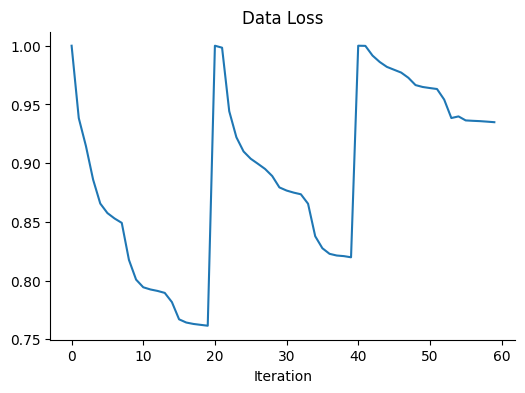

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(loss)
ax.set_title('Data Loss')
ax.set_xlabel('Iteration')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f'{exp_name}/losses.png',  bbox_inches='tight', dpi=300)

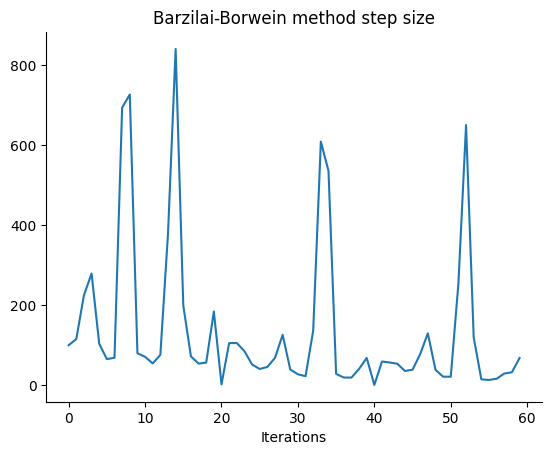

In [15]:
fig, ax = plt.subplots()
ax.plot(alphas)
ax.set_title('Barzilai-Borwein method step size')
ax.set_xlabel('Iterations')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'{exp_name}/alphas.png',  bbox_inches='tight', dpi=300)

## Run FWI with proposed approach $\delta m$

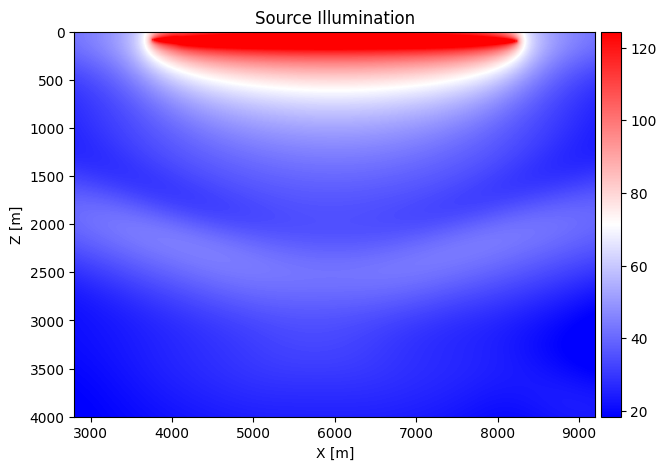

In [ ]:
x_s1, x_r1 = params.get_coordinate('volve')
source_amplitudes = params.create_wavelet(torch.tensor(wavelet), 1)
SI = fwi.source_illumination(model_init, source_amplitudes, par['dx'], par['dt'], x_s1, device=device)
np.savez(f'source_illumination', si=SI.detach().clone().cpu())

simin, simax = np.percentile(SI, [2,98])
show_model(SI, cmap='bwr', vmin=simin, vmax=simax, figsize=(8, 5), extent=(x[0], x[-1], z[-1], z[0]),
           title='Source Illumination', xlim=(2800, 9200), ylim=(4000, 0))
SI = torch.tensor(SI).to(device)

In [11]:
exp_name = 'Exp_Volve_dm'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

  0%|          | 0/60 [00:00<?, ?it/s]

FWI iteration: 0 loss = 9.686514165523691e-14


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.03874122351408005
Training Epoch 1, Loss = 0.03797160089015961
Training Epoch 2, Loss = 0.03726411983370781
Training Epoch 3, Loss = 0.03656110167503357
Training Epoch 4, Loss = 0.03584521263837814
Training Epoch 5, Loss = 0.035121187567710876
Training Epoch 6, Loss = 0.03437670320272446
Training Epoch 7, Loss = 0.033585771918296814
Training Epoch 8, Loss = 0.03273630142211914
Training Epoch 9, Loss = 0.03182455152273178
Training Epoch 10, Loss = 0.030851608142256737
Training Epoch 11, Loss = 0.029813047498464584
Training Epoch 12, Loss = 0.028719132766127586
Training Epoch 13, Loss = 0.027590475976467133
Training Epoch 14, Loss = 0.026450689882040024
Training Epoch 15, Loss = 0.02538350038230419
Training Epoch 16, Loss = 0.02456757239997387
Training Epoch 17, Loss = 0.02446151152253151
Training Epoch 18, Loss = 0.02475990541279316
Training Epoch 19, Loss = 0.02451041340827942
Training Epoch 20, Loss = 0.02384510263800621
Training Epoch 21, Loss = 0.023072676

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.023594899103045464
Training Epoch 1, Loss = 0.017264971509575844
Training Epoch 2, Loss = 0.012009704485535622
Training Epoch 3, Loss = 0.009018991142511368
Training Epoch 4, Loss = 0.00811982061713934
Training Epoch 5, Loss = 0.008267048746347427
Training Epoch 6, Loss = 0.008090296760201454
Training Epoch 7, Loss = 0.007344977930188179
Training Epoch 8, Loss = 0.006539681926369667
Training Epoch 9, Loss = 0.0060346233658492565
Training Epoch 10, Loss = 0.0058268033899366856
Training Epoch 11, Loss = 0.005758610088378191
Training Epoch 12, Loss = 0.0056901429779827595
Training Epoch 13, Loss = 0.005552699323743582
Training Epoch 14, Loss = 0.005330219864845276
Training Epoch 15, Loss = 0.005041196942329407
Training Epoch 16, Loss = 0.004718685057014227
Training Epoch 17, Loss = 0.004396886099129915
Training Epoch 18, Loss = 0.004098975099623203
Training Epoch 19, Loss = 0.00383066781796515
Training Epoch 20, Loss = 0.003588814754039049
Training Epoch 21, Los

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.003695177845656872
Training Epoch 1, Loss = 0.0034117524046450853
Training Epoch 2, Loss = 0.0029961492400616407
Training Epoch 3, Loss = 0.0025836313143372536
Training Epoch 4, Loss = 0.002246083691716194
Training Epoch 5, Loss = 0.0020008450374007225
Training Epoch 6, Loss = 0.0018360085086897016
Training Epoch 7, Loss = 0.0017314727883785963
Training Epoch 8, Loss = 0.001666658092290163
Training Epoch 9, Loss = 0.0016250312328338623
Training Epoch 10, Loss = 0.0015953527763485909
Training Epoch 11, Loss = 0.0015703692333772779
Training Epoch 12, Loss = 0.0015459780115634203
Training Epoch 13, Loss = 0.0015201455680653453
Training Epoch 14, Loss = 0.001492224750109017
Training Epoch 15, Loss = 0.0014622146263718605
Training Epoch 16, Loss = 0.0014306039083749056
Training Epoch 17, Loss = 0.001398215419612825
Training Epoch 18, Loss = 0.0013660506810992956
Training Epoch 19, Loss = 0.0013351585948839784
Training Epoch 20, Loss = 0.0013065275270491838
Trainin

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0010408679954707623
Training Epoch 1, Loss = 0.0010268475161865354
Training Epoch 2, Loss = 0.0010014219442382455
Training Epoch 3, Loss = 0.0009677382186055183
Training Epoch 4, Loss = 0.0009289358276873827
Training Epoch 5, Loss = 0.0008876248029991984
Training Epoch 6, Loss = 0.0008458074880763888
Training Epoch 7, Loss = 0.0008051161421462893
Training Epoch 8, Loss = 0.0007666204473935068
Training Epoch 9, Loss = 0.0007305965409614146
Training Epoch 10, Loss = 0.0006973067647777498
Training Epoch 11, Loss = 0.0006670752773061395
Training Epoch 12, Loss = 0.0006397822871804237
Training Epoch 13, Loss = 0.0006153181893751025
Training Epoch 14, Loss = 0.0005937232635915279
Training Epoch 15, Loss = 0.000574891921132803
Training Epoch 16, Loss = 0.0005586451734416187
Training Epoch 17, Loss = 0.0005447857547551394
Training Epoch 18, Loss = 0.0005330219282768667
Training Epoch 19, Loss = 0.0005231890245340765
Training Epoch 20, Loss = 0.0005151645164005458
Tra

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00035655530518852174
Training Epoch 1, Loss = 0.0003564271901268512
Training Epoch 2, Loss = 0.0003561304765753448
Training Epoch 3, Loss = 0.0003556865849532187
Training Epoch 4, Loss = 0.0003551171685103327
Training Epoch 5, Loss = 0.00035444239620119333
Training Epoch 6, Loss = 0.0003536819713190198
Training Epoch 7, Loss = 0.00035285422927699983
Training Epoch 8, Loss = 0.000351975962985307
Training Epoch 9, Loss = 0.00035106184077449143
Training Epoch 10, Loss = 0.00035012379521504045
Training Epoch 11, Loss = 0.0003491734969429672
Training Epoch 12, Loss = 0.0003482204338070005
Training Epoch 13, Loss = 0.00034727065940387547
Training Epoch 14, Loss = 0.00034633080940693617
Training Epoch 15, Loss = 0.0003454057441558689
Training Epoch 16, Loss = 0.0003444993053562939
Training Epoch 17, Loss = 0.0003436142287682742
Training Epoch 18, Loss = 0.0003427521442063153
Training Epoch 19, Loss = 0.0003419136628508568
Training Epoch 20, Loss = 0.0003410986682865

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0007261211867444217
Training Epoch 1, Loss = 0.000693006906658411
Training Epoch 2, Loss = 0.0006368557806126773
Training Epoch 3, Loss = 0.000570617790799588
Training Epoch 4, Loss = 0.0005050585605204105
Training Epoch 5, Loss = 0.00044717424316331744
Training Epoch 6, Loss = 0.0004000946937594563
Training Epoch 7, Loss = 0.00036418825038708746
Training Epoch 8, Loss = 0.00033816127688623965
Training Epoch 9, Loss = 0.0003200815408490598
Training Epoch 10, Loss = 0.0003079197776969522
Training Epoch 11, Loss = 0.00029981115949340165
Training Epoch 12, Loss = 0.00029429441201500595
Training Epoch 13, Loss = 0.00029030221048742533
Training Epoch 14, Loss = 0.0002870516327675432
Training Epoch 15, Loss = 0.000284012668998912
Training Epoch 16, Loss = 0.000280865904642269
Training Epoch 17, Loss = 0.0002774519089143723
Training Epoch 18, Loss = 0.00027372685144655406
Training Epoch 19, Loss = 0.00026973721105605364
Training Epoch 20, Loss = 0.000265557901002466

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00028998800553381443
Training Epoch 1, Loss = 0.0002859100641217083
Training Epoch 2, Loss = 0.0002785756078083068
Training Epoch 3, Loss = 0.0002692163398023695
Training Epoch 4, Loss = 0.000259033142356202
Training Epoch 5, Loss = 0.0002490170008968562
Training Epoch 6, Loss = 0.00023986774613149464
Training Epoch 7, Loss = 0.00023200211580842733
Training Epoch 8, Loss = 0.00022559687204193324
Training Epoch 9, Loss = 0.00022064673248678446
Training Epoch 10, Loss = 0.00021701568039134145
Training Epoch 11, Loss = 0.00021449863561429083
Training Epoch 12, Loss = 0.00021286832634359598
Training Epoch 13, Loss = 0.00021189061226323247
Training Epoch 14, Loss = 0.00021134989219717681
Training Epoch 15, Loss = 0.00021106564963702112
Training Epoch 16, Loss = 0.00021089045912958682
Training Epoch 17, Loss = 0.0002107128093484789
Training Epoch 18, Loss = 0.00021046063920948654
Training Epoch 19, Loss = 0.00021009323245380074
Training Epoch 20, Loss = 0.000209591

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00019046485249418765
Training Epoch 1, Loss = 0.00019034583237953484
Training Epoch 2, Loss = 0.0001899430062621832
Training Epoch 3, Loss = 0.00018928907229565084
Training Epoch 4, Loss = 0.0001884173252619803
Training Epoch 5, Loss = 0.00018736055062618107
Training Epoch 6, Loss = 0.00018614871078170836
Training Epoch 7, Loss = 0.0001848097745096311
Training Epoch 8, Loss = 0.00018337261280976236
Training Epoch 9, Loss = 0.00018186144006904215
Training Epoch 10, Loss = 0.00018029783677775413
Training Epoch 11, Loss = 0.00017870184092316777
Training Epoch 12, Loss = 0.00017709154053591192
Training Epoch 13, Loss = 0.0001754824334057048
Training Epoch 14, Loss = 0.00017388696142006665
Training Epoch 15, Loss = 0.00017231992387678474
Training Epoch 16, Loss = 0.000170788582181558
Training Epoch 17, Loss = 0.00016930051788222045
Training Epoch 18, Loss = 0.0001678625849308446
Training Epoch 19, Loss = 0.00016647877055220306
Training Epoch 20, Loss = 0.000165150

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00015574581630062312
Training Epoch 1, Loss = 0.00015524453192483634
Training Epoch 2, Loss = 0.00015428666665684432
Training Epoch 3, Loss = 0.00015298815560527146
Training Epoch 4, Loss = 0.00015147148224059492
Training Epoch 5, Loss = 0.00014985523012001067
Training Epoch 6, Loss = 0.00014824075333308429
Training Epoch 7, Loss = 0.0001467111724196002
Training Epoch 8, Loss = 0.00014532421482726932
Training Epoch 9, Loss = 0.00014411451411433518
Training Epoch 10, Loss = 0.00014309237303677946
Training Epoch 11, Loss = 0.00014224932237993926
Training Epoch 12, Loss = 0.0001415653241565451
Training Epoch 13, Loss = 0.00014101053238846362
Training Epoch 14, Loss = 0.00014055082283448428
Training Epoch 15, Loss = 0.00014015303167980164
Training Epoch 16, Loss = 0.00013978779315948486
Training Epoch 17, Loss = 0.00013943188241682947
Training Epoch 18, Loss = 0.00013907067477703094
Training Epoch 19, Loss = 0.00013869687973055989
Training Epoch 20, Loss = 0.0001

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00012596008309628814
Training Epoch 1, Loss = 0.00012589905236382037
Training Epoch 2, Loss = 0.00012572031118907034
Training Epoch 3, Loss = 0.00012544254423119128
Training Epoch 4, Loss = 0.0001250850036740303
Training Epoch 5, Loss = 0.00012466585030779243
Training Epoch 6, Loss = 0.00012420161510817707
Training Epoch 7, Loss = 0.0001237061369465664
Training Epoch 8, Loss = 0.00012318984954617918
Training Epoch 9, Loss = 0.00012266173143871129
Training Epoch 10, Loss = 0.0001221279235323891
Training Epoch 11, Loss = 0.00012159303878434002
Training Epoch 12, Loss = 0.00012105972564313561
Training Epoch 13, Loss = 0.0001205303706228733
Training Epoch 14, Loss = 0.00012000678543699905
Training Epoch 15, Loss = 0.00011949064355576411
Training Epoch 16, Loss = 0.00011898383672814816
Training Epoch 17, Loss = 0.00011848778376588598
Training Epoch 18, Loss = 0.00011800380161730573
Training Epoch 19, Loss = 0.00011753328726626933
Training Epoch 20, Loss = 0.000117

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00011402180098230019
Training Epoch 1, Loss = 0.00011366826947778463
Training Epoch 2, Loss = 0.00011302952043479308
Training Epoch 3, Loss = 0.00011218307190574706
Training Epoch 4, Loss = 0.00011120944691356272
Training Epoch 5, Loss = 0.0001101834568544291
Training Epoch 6, Loss = 0.00010916740575339645
Training Epoch 7, Loss = 0.0001082096277968958
Training Epoch 8, Loss = 0.00010734178067650646
Training Epoch 9, Loss = 0.00010658113023964688
Training Epoch 10, Loss = 0.00010593300248729065
Training Epoch 11, Loss = 0.00010539298818912357
Training Epoch 12, Loss = 0.00010495020978851244
Training Epoch 13, Loss = 0.00010459139593876898
Training Epoch 14, Loss = 0.0001043033626046963
Training Epoch 15, Loss = 0.00010407096124254167
Training Epoch 16, Loss = 0.00010388001828687266
Training Epoch 17, Loss = 0.00010371800453867763
Training Epoch 18, Loss = 0.00010357482096878812
Training Epoch 19, Loss = 0.0001034426677506417
Training Epoch 20, Loss = 0.000103

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00011782215733546764
Training Epoch 1, Loss = 0.00011770550190703943
Training Epoch 2, Loss = 0.00011749265104299411
Training Epoch 3, Loss = 0.00011720570910256356
Training Epoch 4, Loss = 0.0001168673115898855
Training Epoch 5, Loss = 0.00011649832595139742
Training Epoch 6, Loss = 0.00011611579975578934
Training Epoch 7, Loss = 0.00011573183292057365
Training Epoch 8, Loss = 0.0001153535777120851
Training Epoch 9, Loss = 0.0001149839154095389
Training Epoch 10, Loss = 0.00011462251131888479
Training Epoch 11, Loss = 0.00011426758283050731
Training Epoch 12, Loss = 0.00011391582665964961
Training Epoch 13, Loss = 0.00011356499453540891
Training Epoch 14, Loss = 0.00011321326019242406
Training Epoch 15, Loss = 0.0001128604490077123
Training Epoch 16, Loss = 0.00011250805255258456
Training Epoch 17, Loss = 0.0001121583700296469
Training Epoch 18, Loss = 0.0001118149230023846
Training Epoch 19, Loss = 0.00011148082558065653
Training Epoch 20, Loss = 0.00011115

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00013241471606306732
Training Epoch 1, Loss = 0.00013143349497113377
Training Epoch 2, Loss = 0.00012960380990989506
Training Epoch 3, Loss = 0.0001271960645681247
Training Epoch 4, Loss = 0.00012448446068447083
Training Epoch 5, Loss = 0.00012170442641945556
Training Epoch 6, Loss = 0.00011904135317308828
Training Epoch 7, Loss = 0.00011661798635032028
Training Epoch 8, Loss = 0.00011449186422396451
Training Epoch 9, Loss = 0.00011267737863818184
Training Epoch 10, Loss = 0.00011115877714473754
Training Epoch 11, Loss = 0.00010990106966346502
Training Epoch 12, Loss = 0.0001088551216525957
Training Epoch 13, Loss = 0.00010798167204484344
Training Epoch 14, Loss = 0.00010723731247708201
Training Epoch 15, Loss = 0.00010658655082806945
Training Epoch 16, Loss = 0.00010599794040899724
Training Epoch 17, Loss = 0.00010544664110057056
Training Epoch 18, Loss = 0.00010491554712643847
Training Epoch 19, Loss = 0.00010439301695441827
Training Epoch 20, Loss = 0.0001

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00010322781599825248
Training Epoch 1, Loss = 0.00010294631647411734
Training Epoch 2, Loss = 0.00010242928692605346
Training Epoch 3, Loss = 0.00010176803334616125
Training Epoch 4, Loss = 0.00010105252295034006
Training Epoch 5, Loss = 0.00010035417653853074
Training Epoch 6, Loss = 9.971688996301964e-05
Training Epoch 7, Loss = 9.915587725117803e-05
Training Epoch 8, Loss = 9.866333130048588e-05
Training Epoch 9, Loss = 9.821660205489025e-05
Training Epoch 10, Loss = 9.778996172826737e-05
Training Epoch 11, Loss = 9.736244101077318e-05
Training Epoch 12, Loss = 9.692452294984832e-05
Training Epoch 13, Loss = 9.647752449382097e-05
Training Epoch 14, Loss = 9.603137732483447e-05
Training Epoch 15, Loss = 9.560029866406694e-05
Training Epoch 16, Loss = 9.51998881646432e-05
Training Epoch 17, Loss = 9.484153270022944e-05
Training Epoch 18, Loss = 9.45300271268934e-05
Training Epoch 19, Loss = 9.426390170119703e-05
Training Epoch 20, Loss = 9.40368408919312e-05

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.493211498716846e-05
Training Epoch 1, Loss = 8.467219595331699e-05
Training Epoch 2, Loss = 8.422122482443228e-05
Training Epoch 3, Loss = 8.367979171453044e-05
Training Epoch 4, Loss = 8.313811849802732e-05
Training Epoch 5, Loss = 8.265629730885848e-05
Training Epoch 6, Loss = 8.225531928474084e-05
Training Epoch 7, Loss = 8.192470704670995e-05
Training Epoch 8, Loss = 8.163385791704059e-05
Training Epoch 9, Loss = 8.134735253406689e-05
Training Epoch 10, Loss = 8.103832078631967e-05
Training Epoch 11, Loss = 8.069595787674189e-05
Training Epoch 12, Loss = 8.03255315986462e-05
Training Epoch 13, Loss = 7.99435656517744e-05
Training Epoch 14, Loss = 7.95735904830508e-05
Training Epoch 15, Loss = 7.923638622742146e-05
Training Epoch 16, Loss = 7.894320879131556e-05
Training Epoch 17, Loss = 7.869582623243332e-05
Training Epoch 18, Loss = 7.848670793464407e-05
Training Epoch 19, Loss = 7.830207323422655e-05
Training Epoch 20, Loss = 7.812635885784402e-05
Train

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.461469795089215e-05
Training Epoch 1, Loss = 7.446511881425977e-05
Training Epoch 2, Loss = 7.423041824949905e-05
Training Epoch 3, Loss = 7.396913861157373e-05
Training Epoch 4, Loss = 7.373221160378307e-05
Training Epoch 5, Loss = 7.354859553743154e-05
Training Epoch 6, Loss = 7.34210989321582e-05
Training Epoch 7, Loss = 7.33304041204974e-05
Training Epoch 8, Loss = 7.324644684558734e-05
Training Epoch 9, Loss = 7.314114191103727e-05
Training Epoch 10, Loss = 7.299718708964065e-05
Training Epoch 11, Loss = 7.281293801497668e-05
Training Epoch 12, Loss = 7.260023267008364e-05
Training Epoch 13, Loss = 7.237873796839267e-05
Training Epoch 14, Loss = 7.216727681225166e-05
Training Epoch 15, Loss = 7.197901868494228e-05
Training Epoch 16, Loss = 7.181779074016958e-05
Training Epoch 17, Loss = 7.167979492805898e-05
Training Epoch 18, Loss = 7.155549246817827e-05
Training Epoch 19, Loss = 7.143402035580948e-05
Training Epoch 20, Loss = 7.13072222424671e-05
Train

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.88563770079054e-05
Training Epoch 1, Loss = 9.787255112314597e-05
Training Epoch 2, Loss = 9.615248563932255e-05
Training Epoch 3, Loss = 9.398877591593191e-05
Training Epoch 4, Loss = 9.165334631688893e-05
Training Epoch 5, Loss = 8.935798541642725e-05
Training Epoch 6, Loss = 8.721296762814745e-05
Training Epoch 7, Loss = 8.526963938493282e-05
Training Epoch 8, Loss = 8.354050805792212e-05
Training Epoch 9, Loss = 8.200930460589007e-05
Training Epoch 10, Loss = 8.065990550676361e-05
Training Epoch 11, Loss = 7.946625555632636e-05
Training Epoch 12, Loss = 7.841083424864337e-05
Training Epoch 13, Loss = 7.746963819954544e-05
Training Epoch 14, Loss = 7.662321877432987e-05
Training Epoch 15, Loss = 7.585145067423582e-05
Training Epoch 16, Loss = 7.51414627302438e-05
Training Epoch 17, Loss = 7.447958341799676e-05
Training Epoch 18, Loss = 7.385793287539855e-05
Training Epoch 19, Loss = 7.327262574108317e-05
Training Epoch 20, Loss = 7.27217920939438e-05
Train

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.336640944937244e-05
Training Epoch 1, Loss = 6.324266723822802e-05
Training Epoch 2, Loss = 6.301867688307539e-05
Training Epoch 3, Loss = 6.27207409706898e-05
Training Epoch 4, Loss = 6.237617344595492e-05
Training Epoch 5, Loss = 6.200923962751403e-05
Training Epoch 6, Loss = 6.163987563923001e-05
Training Epoch 7, Loss = 6.128255336079746e-05
Training Epoch 8, Loss = 6.094705531722866e-05
Training Epoch 9, Loss = 6.0638139984803274e-05
Training Epoch 10, Loss = 6.0356636822689325e-05
Training Epoch 11, Loss = 6.010191282257438e-05
Training Epoch 12, Loss = 5.987130862195045e-05
Training Epoch 13, Loss = 5.966091339359991e-05
Training Epoch 14, Loss = 5.946727469563484e-05
Training Epoch 15, Loss = 5.9287529438734055e-05
Training Epoch 16, Loss = 5.91190364502836e-05
Training Epoch 17, Loss = 5.895976573810913e-05
Training Epoch 18, Loss = 5.880797834834084e-05
Training Epoch 19, Loss = 5.8662964875111356e-05
Training Epoch 20, Loss = 5.8523692132439464e-05

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.860023884451948e-05
Training Epoch 1, Loss = 5.8326299040345475e-05
Training Epoch 2, Loss = 5.7853696489473805e-05
Training Epoch 3, Loss = 5.7264845963800326e-05
Training Epoch 4, Loss = 5.6642747949808836e-05
Training Epoch 5, Loss = 5.6049997510854155e-05
Training Epoch 6, Loss = 5.5525331845274195e-05
Training Epoch 7, Loss = 5.507976675289683e-05
Training Epoch 8, Loss = 5.4709118558093905e-05
Training Epoch 9, Loss = 5.440063978312537e-05
Training Epoch 10, Loss = 5.4140484280651435e-05
Training Epoch 11, Loss = 5.391667582443915e-05
Training Epoch 12, Loss = 5.371765291783959e-05
Training Epoch 13, Loss = 5.353276719688438e-05
Training Epoch 14, Loss = 5.3355455747805536e-05
Training Epoch 15, Loss = 5.318262992659584e-05
Training Epoch 16, Loss = 5.301302007865161e-05
Training Epoch 17, Loss = 5.284613143885508e-05
Training Epoch 18, Loss = 5.268284439807758e-05
Training Epoch 19, Loss = 5.252407936495729e-05
Training Epoch 20, Loss = 5.2371040510479

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.4288040701067075e-05
Training Epoch 1, Loss = 5.36800071131438e-05
Training Epoch 2, Loss = 5.265391882858239e-05
Training Epoch 3, Loss = 5.143437738297507e-05
Training Epoch 4, Loss = 5.017773582949303e-05
Training Epoch 5, Loss = 4.895200254395604e-05
Training Epoch 6, Loss = 4.77810826851055e-05
Training Epoch 7, Loss = 4.6685101551702246e-05
Training Epoch 8, Loss = 4.568877557176165e-05
Training Epoch 9, Loss = 4.481742507778108e-05
Training Epoch 10, Loss = 4.4078202336095273e-05
Training Epoch 11, Loss = 4.3455100239953026e-05
Training Epoch 12, Loss = 4.292237645131536e-05
Training Epoch 13, Loss = 4.245891614118591e-05
Training Epoch 14, Loss = 4.205743607599288e-05
Training Epoch 15, Loss = 4.172108674538322e-05
Training Epoch 16, Loss = 4.1452585719525814e-05
Training Epoch 17, Loss = 4.124755650991574e-05
Training Epoch 18, Loss = 4.108852590434253e-05
Training Epoch 19, Loss = 4.0954011637950316e-05
Training Epoch 20, Loss = 4.082894156454131e-0

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.009554838761687279
Training Epoch 1, Loss = 0.009380019269883633
Training Epoch 2, Loss = 0.009226663038134575
Training Epoch 3, Loss = 0.009087560698390007
Training Epoch 4, Loss = 0.008968386799097061
Training Epoch 5, Loss = 0.008861556649208069
Training Epoch 6, Loss = 0.008762912824749947
Training Epoch 7, Loss = 0.008664734661579132
Training Epoch 8, Loss = 0.00856894813477993
Training Epoch 9, Loss = 0.008473098278045654
Training Epoch 10, Loss = 0.008376453071832657
Training Epoch 11, Loss = 0.008280336856842041
Training Epoch 12, Loss = 0.008186684921383858
Training Epoch 13, Loss = 0.008100200444459915
Training Epoch 14, Loss = 0.008027390576899052
Training Epoch 15, Loss = 0.007971206679940224
Training Epoch 16, Loss = 0.007925926707684994
Training Epoch 17, Loss = 0.007871613837778568
Training Epoch 18, Loss = 0.007793426979333162
Training Epoch 19, Loss = 0.0076889172196388245
Training Epoch 20, Loss = 0.00756323616951704
Training Epoch 21, Loss 

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0025632325559854507
Training Epoch 1, Loss = 0.0015869722701609135
Training Epoch 2, Loss = 0.001028197119012475
Training Epoch 3, Loss = 0.0007799718296155334
Training Epoch 4, Loss = 0.0006490507512353361
Training Epoch 5, Loss = 0.0005648784572258592
Training Epoch 6, Loss = 0.0005146537441760302
Training Epoch 7, Loss = 0.00048760577919892967
Training Epoch 8, Loss = 0.0004732875095214695
Training Epoch 9, Loss = 0.0004628848400898278
Training Epoch 10, Loss = 0.0004523655807133764
Training Epoch 11, Loss = 0.000441148120444268
Training Epoch 12, Loss = 0.00043012204696424305
Training Epoch 13, Loss = 0.00042032383498735726
Training Epoch 14, Loss = 0.00041241812868975103
Training Epoch 15, Loss = 0.0004063667729496956
Training Epoch 16, Loss = 0.00040162436198443174
Training Epoch 17, Loss = 0.00039750130963511765
Training Epoch 18, Loss = 0.00039343602838926017
Training Epoch 19, Loss = 0.0003891092783305794
Training Epoch 20, Loss = 0.00038439349737018

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00021842110436409712
Training Epoch 1, Loss = 0.00020725718059111387
Training Epoch 2, Loss = 0.00019493073341436684
Training Epoch 3, Loss = 0.00018735475896392018
Training Epoch 4, Loss = 0.00018230194109492004
Training Epoch 5, Loss = 0.0001752802199916914
Training Epoch 6, Loss = 0.0001660400885157287
Training Epoch 7, Loss = 0.00015749465092085302
Training Epoch 8, Loss = 0.00015194440493360162
Training Epoch 9, Loss = 0.00014944616123102605
Training Epoch 10, Loss = 0.00014818889030721039
Training Epoch 11, Loss = 0.00014611663937103003
Training Epoch 12, Loss = 0.0001427354000043124
Training Epoch 13, Loss = 0.00013908969413023442
Training Epoch 14, Loss = 0.0001362517650704831
Training Epoch 15, Loss = 0.0001344248012173921
Training Epoch 16, Loss = 0.0001330174127360806
Training Epoch 17, Loss = 0.00013135038898326457
Training Epoch 18, Loss = 0.00012920740118715912
Training Epoch 19, Loss = 0.00012690952280536294
Training Epoch 20, Loss = 0.00012498

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00020398595370352268
Training Epoch 1, Loss = 0.0001882190117612481
Training Epoch 2, Loss = 0.00017737195594236255
Training Epoch 3, Loss = 0.00016743522428441793
Training Epoch 4, Loss = 0.00015027739573270082
Training Epoch 5, Loss = 0.00013368665531743318
Training Epoch 6, Loss = 0.00012473492824938148
Training Epoch 7, Loss = 0.00011996471585007384
Training Epoch 8, Loss = 0.00011412325693527237
Training Epoch 9, Loss = 0.00010855886648641899
Training Epoch 10, Loss = 0.00010610299796098843
Training Epoch 11, Loss = 0.00010577453213045374
Training Epoch 12, Loss = 0.00010489457781659439
Training Epoch 13, Loss = 0.0001026047975756228
Training Epoch 14, Loss = 9.999710891861469e-05
Training Epoch 15, Loss = 9.819693514145911e-05
Training Epoch 16, Loss = 9.701611270429567e-05
Training Epoch 17, Loss = 9.546807268634439e-05
Training Epoch 18, Loss = 9.31612157728523e-05
Training Epoch 19, Loss = 9.069123916560784e-05
Training Epoch 20, Loss = 8.87633141246

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0001798048906493932
Training Epoch 1, Loss = 0.00017016044876072556
Training Epoch 2, Loss = 0.00015565817011520267
Training Epoch 3, Loss = 0.0001407125819241628
Training Epoch 4, Loss = 0.0001277923583984375
Training Epoch 5, Loss = 0.00011770248238462955
Training Epoch 6, Loss = 0.00011049628665205091
Training Epoch 7, Loss = 0.00010558562644291669
Training Epoch 8, Loss = 0.00010200597898801789
Training Epoch 9, Loss = 9.9092663731426e-05
Training Epoch 10, Loss = 9.653242159401998e-05
Training Epoch 11, Loss = 9.414680971531197e-05
Training Epoch 12, Loss = 9.187645628117025e-05
Training Epoch 13, Loss = 8.964150038082153e-05
Training Epoch 14, Loss = 8.742042700760067e-05
Training Epoch 15, Loss = 8.530781633453444e-05
Training Epoch 16, Loss = 8.337491453858092e-05
Training Epoch 17, Loss = 8.164985774783418e-05
Training Epoch 18, Loss = 8.009162411326542e-05
Training Epoch 19, Loss = 7.861882477300242e-05
Training Epoch 20, Loss = 7.719202403677627e-0

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00017966398445423692
Training Epoch 1, Loss = 0.00013272196520119905
Training Epoch 2, Loss = 0.0001515596522949636
Training Epoch 3, Loss = 0.00011442347022239119
Training Epoch 4, Loss = 0.00011935909424209967
Training Epoch 5, Loss = 0.00010188647866016254
Training Epoch 6, Loss = 8.846279524732381e-05
Training Epoch 7, Loss = 0.00010102194937644526
Training Epoch 8, Loss = 9.669260907685384e-05
Training Epoch 9, Loss = 8.247576624853536e-05
Training Epoch 10, Loss = 7.784544141031802e-05
Training Epoch 11, Loss = 7.573577022412792e-05
Training Epoch 12, Loss = 7.452636054949835e-05
Training Epoch 13, Loss = 7.363235636148602e-05
Training Epoch 14, Loss = 7.027837273199111e-05
Training Epoch 15, Loss = 6.53483293717727e-05
Training Epoch 16, Loss = 6.2494000303559e-05
Training Epoch 17, Loss = 6.169945845613256e-05
Training Epoch 18, Loss = 6.043934263288975e-05
Training Epoch 19, Loss = 5.8909070503432304e-05
Training Epoch 20, Loss = 5.781069557997398e-0

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.65259168879129e-05
Training Epoch 1, Loss = 9.043601312441751e-05
Training Epoch 2, Loss = 8.227319631259888e-05
Training Epoch 3, Loss = 7.509211718570441e-05
Training Epoch 4, Loss = 7.075046596582979e-05
Training Epoch 5, Loss = 6.886337359901518e-05
Training Epoch 6, Loss = 6.756688526365906e-05
Training Epoch 7, Loss = 6.58226344967261e-05
Training Epoch 8, Loss = 6.336251681204885e-05
Training Epoch 9, Loss = 6.04261331318412e-05
Training Epoch 10, Loss = 5.78376893827226e-05
Training Epoch 11, Loss = 5.6189259339589626e-05
Training Epoch 12, Loss = 5.54079633729998e-05
Training Epoch 13, Loss = 5.51576231373474e-05
Training Epoch 14, Loss = 5.500426414073445e-05
Training Epoch 15, Loss = 5.450064782053232e-05
Training Epoch 16, Loss = 5.355636676540598e-05
Training Epoch 17, Loss = 5.2367195166880265e-05
Training Epoch 18, Loss = 5.112615326652303e-05
Training Epoch 19, Loss = 5.001035242457874e-05
Training Epoch 20, Loss = 4.916645775665529e-05
Traini

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.820531365927309e-05
Training Epoch 1, Loss = 7.3529954534024e-05
Training Epoch 2, Loss = 7.078719499986619e-05
Training Epoch 3, Loss = 5.1739716582233086e-05
Training Epoch 4, Loss = 6.145599036244676e-05
Training Epoch 5, Loss = 4.7163521230686456e-05
Training Epoch 6, Loss = 5.311417407938279e-05
Training Epoch 7, Loss = 4.998358053853735e-05
Training Epoch 8, Loss = 4.529727084445767e-05
Training Epoch 9, Loss = 4.5541528379544616e-05
Training Epoch 10, Loss = 3.994481812696904e-05
Training Epoch 11, Loss = 3.934196865884587e-05
Training Epoch 12, Loss = 3.9378250221489e-05
Training Epoch 13, Loss = 3.601856224122457e-05
Training Epoch 14, Loss = 3.553751957952045e-05
Training Epoch 15, Loss = 3.551150803104974e-05
Training Epoch 16, Loss = 3.331594416522421e-05
Training Epoch 17, Loss = 3.3088112104451284e-05
Training Epoch 18, Loss = 3.30705261148978e-05
Training Epoch 19, Loss = 3.10052273562178e-05
Training Epoch 20, Loss = 3.063118128920905e-05
Trai

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.949999103904702e-05
Training Epoch 1, Loss = 5.628930375678465e-05
Training Epoch 2, Loss = 5.247412627795711e-05
Training Epoch 3, Loss = 4.938651909469627e-05
Training Epoch 4, Loss = 4.7296554839704186e-05
Training Epoch 5, Loss = 4.53284737886861e-05
Training Epoch 6, Loss = 4.339305087341927e-05
Training Epoch 7, Loss = 4.142937541473657e-05
Training Epoch 8, Loss = 3.977152664447203e-05
Training Epoch 9, Loss = 3.872452725772746e-05
Training Epoch 10, Loss = 3.8024427340133116e-05
Training Epoch 11, Loss = 3.7350193451857194e-05
Training Epoch 12, Loss = 3.639297574409284e-05
Training Epoch 13, Loss = 3.5381410270929337e-05
Training Epoch 14, Loss = 3.458085848251358e-05
Training Epoch 15, Loss = 3.407449185033329e-05
Training Epoch 16, Loss = 3.379228655830957e-05
Training Epoch 17, Loss = 3.343457865412347e-05
Training Epoch 18, Loss = 3.292774272267707e-05
Training Epoch 19, Loss = 3.232858216506429e-05
Training Epoch 20, Loss = 3.177789767505601e-05

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00011849201837321743
Training Epoch 1, Loss = 0.00022260066180024296
Training Epoch 2, Loss = 7.947811536723748e-05
Training Epoch 3, Loss = 0.00016171467723324895
Training Epoch 4, Loss = 8.258753223344684e-05
Training Epoch 5, Loss = 8.197021816158667e-05
Training Epoch 6, Loss = 0.00010113025928149
Training Epoch 7, Loss = 7.98636901890859e-05
Training Epoch 8, Loss = 5.539376797969453e-05
Training Epoch 9, Loss = 6.67058484395966e-05
Training Epoch 10, Loss = 7.612013723701239e-05
Training Epoch 11, Loss = 5.7462300901534036e-05
Training Epoch 12, Loss = 4.761421951116063e-05
Training Epoch 13, Loss = 5.519303522305563e-05
Training Epoch 14, Loss = 6.13221709500067e-05
Training Epoch 15, Loss = 5.512777352123521e-05
Training Epoch 16, Loss = 4.4434393203118816e-05
Training Epoch 17, Loss = 4.193502172711305e-05
Training Epoch 18, Loss = 4.758368959301151e-05
Training Epoch 19, Loss = 4.8496709496248513e-05
Training Epoch 20, Loss = 4.197507587377913e-05
T

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.44288476096699e-05
Training Epoch 1, Loss = 2.3573837097501382e-05
Training Epoch 2, Loss = 2.2963682567933574e-05
Training Epoch 3, Loss = 2.2249672838370316e-05
Training Epoch 4, Loss = 2.1879688574699685e-05
Training Epoch 5, Loss = 2.1640615159412846e-05
Training Epoch 6, Loss = 2.1153675334062427e-05
Training Epoch 7, Loss = 2.0868563296971843e-05
Training Epoch 8, Loss = 2.0528286768239923e-05
Training Epoch 9, Loss = 2.0166018657619134e-05
Training Epoch 10, Loss = 1.9929562768083997e-05
Training Epoch 11, Loss = 1.966728268598672e-05
Training Epoch 12, Loss = 1.9510607671691105e-05
Training Epoch 13, Loss = 1.9326309484313242e-05
Training Epoch 14, Loss = 1.9082002836512402e-05
Training Epoch 15, Loss = 1.8902335796155967e-05
Training Epoch 16, Loss = 1.872631582955364e-05
Training Epoch 17, Loss = 1.8590533727547154e-05
Training Epoch 18, Loss = 1.845050064730458e-05
Training Epoch 19, Loss = 1.828155291150324e-05
Training Epoch 20, Loss = 1.81608065

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.0344413466518745e-05
Training Epoch 1, Loss = 4.495670145843178e-05
Training Epoch 2, Loss = 4.259502384229563e-05
Training Epoch 3, Loss = 3.821169229922816e-05
Training Epoch 4, Loss = 3.615178502514027e-05
Training Epoch 5, Loss = 3.4259679523529485e-05
Training Epoch 6, Loss = 3.153154466417618e-05
Training Epoch 7, Loss = 3.089727397309616e-05
Training Epoch 8, Loss = 2.9380169507930987e-05
Training Epoch 9, Loss = 2.8127778932685032e-05
Training Epoch 10, Loss = 2.771351682895329e-05
Training Epoch 11, Loss = 2.707176645344589e-05
Training Epoch 12, Loss = 2.6352028726250865e-05
Training Epoch 13, Loss = 2.5593935788492672e-05
Training Epoch 14, Loss = 2.4700677386135794e-05
Training Epoch 15, Loss = 2.4081671654130332e-05
Training Epoch 16, Loss = 2.3455835616914555e-05
Training Epoch 17, Loss = 2.2628724764217623e-05
Training Epoch 18, Loss = 2.2335701942211017e-05
Training Epoch 19, Loss = 2.2076754248701036e-05
Training Epoch 20, Loss = 2.1543159164

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0004560760280583054
Training Epoch 1, Loss = 0.0006914572441019118
Training Epoch 2, Loss = 0.0003163684159517288
Training Epoch 3, Loss = 0.00015648381668142974
Training Epoch 4, Loss = 0.0002445834979880601
Training Epoch 5, Loss = 0.0002688955282792449
Training Epoch 6, Loss = 0.0002129298372892663
Training Epoch 7, Loss = 0.0001651244529057294
Training Epoch 8, Loss = 0.00015886264736764133
Training Epoch 9, Loss = 0.0001596806978341192
Training Epoch 10, Loss = 0.00014585474855266511
Training Epoch 11, Loss = 0.0001253542141057551
Training Epoch 12, Loss = 0.00011482435365905985
Training Epoch 13, Loss = 0.0001174836143036373
Training Epoch 14, Loss = 0.00011345974053256214
Training Epoch 15, Loss = 9.750029857968912e-05
Training Epoch 16, Loss = 8.387170237256214e-05
Training Epoch 17, Loss = 8.021260873647407e-05
Training Epoch 18, Loss = 8.265268115792423e-05
Training Epoch 19, Loss = 8.610992517787963e-05
Training Epoch 20, Loss = 8.76004560268484e-0

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.0221366867190227e-05
Training Epoch 1, Loss = 2.0112638594582677e-05
Training Epoch 2, Loss = 1.99973310373025e-05
Training Epoch 3, Loss = 1.9891196643584408e-05
Training Epoch 4, Loss = 1.976855674001854e-05
Training Epoch 5, Loss = 1.9634706404758617e-05
Training Epoch 6, Loss = 1.9514753148541786e-05
Training Epoch 7, Loss = 1.9408349544391967e-05
Training Epoch 8, Loss = 1.930214602907654e-05
Training Epoch 9, Loss = 1.919464921229519e-05
Training Epoch 10, Loss = 1.909041020553559e-05
Training Epoch 11, Loss = 1.899142807815224e-05
Training Epoch 12, Loss = 1.8900222130469047e-05
Training Epoch 13, Loss = 1.8815993826137856e-05
Training Epoch 14, Loss = 1.872946995717939e-05
Training Epoch 15, Loss = 1.8640603229869157e-05
Training Epoch 16, Loss = 1.8557448129286058e-05
Training Epoch 17, Loss = 1.8478251149645075e-05
Training Epoch 18, Loss = 1.8396147424937226e-05
Training Epoch 19, Loss = 1.8315244233235717e-05
Training Epoch 20, Loss = 1.8242018995

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4741342965862714e-05
Training Epoch 1, Loss = 1.4628051758336369e-05
Training Epoch 2, Loss = 1.4473168448603246e-05
Training Epoch 3, Loss = 1.4309881407825742e-05
Training Epoch 4, Loss = 1.4163932064548135e-05
Training Epoch 5, Loss = 1.4031959835847374e-05
Training Epoch 6, Loss = 1.3903873878007289e-05
Training Epoch 7, Loss = 1.3786007912131026e-05
Training Epoch 8, Loss = 1.368352423014585e-05
Training Epoch 9, Loss = 1.3597241377283353e-05
Training Epoch 10, Loss = 1.351664923276985e-05
Training Epoch 11, Loss = 1.3434739230433479e-05
Training Epoch 12, Loss = 1.335163506155368e-05
Training Epoch 13, Loss = 1.3267001122585498e-05
Training Epoch 14, Loss = 1.3188089724280871e-05
Training Epoch 15, Loss = 1.3118771676090546e-05
Training Epoch 16, Loss = 1.3057903743174393e-05
Training Epoch 17, Loss = 1.3005686923861504e-05
Training Epoch 18, Loss = 1.2958965271536727e-05
Training Epoch 19, Loss = 1.2914575563627295e-05
Training Epoch 20, Loss = 1.28706

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1590014764806256e-05
Training Epoch 1, Loss = 1.1475877727207262e-05
Training Epoch 2, Loss = 1.1363087651261594e-05
Training Epoch 3, Loss = 1.1264864042459521e-05
Training Epoch 4, Loss = 1.1140676178911235e-05
Training Epoch 5, Loss = 1.1072432243963704e-05
Training Epoch 6, Loss = 1.0961015505017713e-05
Training Epoch 7, Loss = 1.0903475413215347e-05
Training Epoch 8, Loss = 1.0838973139470909e-05
Training Epoch 9, Loss = 1.0788155123009346e-05
Training Epoch 10, Loss = 1.0718363228079397e-05
Training Epoch 11, Loss = 1.0666251000657212e-05
Training Epoch 12, Loss = 1.062365117832087e-05
Training Epoch 13, Loss = 1.0570287486189045e-05
Training Epoch 14, Loss = 1.0548758837103378e-05
Training Epoch 15, Loss = 1.0496140930627007e-05
Training Epoch 16, Loss = 1.0467541869729757e-05
Training Epoch 17, Loss = 1.0429384929011576e-05
Training Epoch 18, Loss = 1.0398642189102247e-05
Training Epoch 19, Loss = 1.0368870789534412e-05
Training Epoch 20, Loss = 1.033

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.163355409516953e-05
Training Epoch 1, Loss = 1.1876784810738172e-05
Training Epoch 2, Loss = 1.218783472722862e-05
Training Epoch 3, Loss = 1.1922222256544046e-05
Training Epoch 4, Loss = 1.1150636964885052e-05
Training Epoch 5, Loss = 1.1344221093168017e-05
Training Epoch 6, Loss = 1.2903202332381625e-05
Training Epoch 7, Loss = 1.4593128980777692e-05
Training Epoch 8, Loss = 1.3280225175549276e-05
Training Epoch 9, Loss = 1.12042689579539e-05
Training Epoch 10, Loss = 1.0453332834003959e-05
Training Epoch 11, Loss = 1.0981096238538157e-05
Training Epoch 12, Loss = 1.1332208487147e-05
Training Epoch 13, Loss = 1.0669529729057103e-05
Training Epoch 14, Loss = 9.897712516249157e-06
Training Epoch 15, Loss = 1.031050669553224e-05
Training Epoch 16, Loss = 1.0568282959866337e-05
Training Epoch 17, Loss = 9.5848099590512e-06
Training Epoch 18, Loss = 9.641166798246559e-06
Training Epoch 19, Loss = 1.0231597116217017e-05
Training Epoch 20, Loss = 9.527659130981192

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1043163794965949e-05
Training Epoch 1, Loss = 1.2117101505282335e-05
Training Epoch 2, Loss = 1.5734221960883588e-05
Training Epoch 3, Loss = 2.1893709345022216e-05
Training Epoch 4, Loss = 1.9560326109058224e-05
Training Epoch 5, Loss = 1.1292524504824542e-05
Training Epoch 6, Loss = 1.460541443520924e-05
Training Epoch 7, Loss = 1.7787493561627343e-05
Training Epoch 8, Loss = 9.945673809852451e-06
Training Epoch 9, Loss = 1.3391229913395364e-05
Training Epoch 10, Loss = 1.224010338773951e-05
Training Epoch 11, Loss = 1.096142932510702e-05
Training Epoch 12, Loss = 1.2483632417570334e-05
Training Epoch 13, Loss = 9.166116797132418e-06
Training Epoch 14, Loss = 1.218955367221497e-05
Training Epoch 15, Loss = 9.482502719038166e-06
Training Epoch 16, Loss = 1.0627295523590874e-05
Training Epoch 17, Loss = 9.61685145739466e-06
Training Epoch 18, Loss = 9.995636901294347e-06
Training Epoch 19, Loss = 9.434331332158763e-06
Training Epoch 20, Loss = 9.1966776381013

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5627332686563022e-05
Training Epoch 1, Loss = 2.1501393348444253e-05
Training Epoch 2, Loss = 2.993760244862642e-05
Training Epoch 3, Loss = 4.41421361756511e-05
Training Epoch 4, Loss = 2.3807942852727138e-05
Training Epoch 5, Loss = 1.3883841347706039e-05
Training Epoch 6, Loss = 2.0509194655460306e-05
Training Epoch 7, Loss = 1.5922882084851153e-05
Training Epoch 8, Loss = 1.3593291441793554e-05
Training Epoch 9, Loss = 1.6023695934563875e-05
Training Epoch 10, Loss = 1.2328495358815417e-05
Training Epoch 11, Loss = 1.4043436749489047e-05
Training Epoch 12, Loss = 1.2729441550618503e-05
Training Epoch 13, Loss = 1.1677598195092287e-05
Training Epoch 14, Loss = 1.2843766853620764e-05
Training Epoch 15, Loss = 1.0170206223847345e-05
Training Epoch 16, Loss = 1.2196714124002028e-05
Training Epoch 17, Loss = 9.594458788342308e-06
Training Epoch 18, Loss = 1.1561292012629565e-05
Training Epoch 19, Loss = 9.423626579518896e-06
Training Epoch 20, Loss = 1.0619431

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.025392884912435e-05
Training Epoch 1, Loss = 1.1740153240680229e-05
Training Epoch 2, Loss = 1.3893256436858792e-05
Training Epoch 3, Loss = 1.7892301912070252e-05
Training Epoch 4, Loss = 1.949847319338005e-05
Training Epoch 5, Loss = 2.4446459065075032e-05
Training Epoch 6, Loss = 1.7051723261829466e-05
Training Epoch 7, Loss = 1.1189470569661353e-05
Training Epoch 8, Loss = 1.0704022315621842e-05
Training Epoch 9, Loss = 1.3168222722015344e-05
Training Epoch 10, Loss = 1.205971057061106e-05
Training Epoch 11, Loss = 9.247482012142427e-06
Training Epoch 12, Loss = 1.1735978659999091e-05
Training Epoch 13, Loss = 1.0914724043686874e-05
Training Epoch 14, Loss = 8.803141099633649e-06
Training Epoch 15, Loss = 1.0996782293659635e-05
Training Epoch 16, Loss = 9.459340617468115e-06
Training Epoch 17, Loss = 8.804877325019334e-06
Training Epoch 18, Loss = 9.788833267521113e-06
Training Epoch 19, Loss = 8.54158861329779e-06
Training Epoch 20, Loss = 8.625440386822

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.012366252020001411
Training Epoch 1, Loss = 0.011971503496170044
Training Epoch 2, Loss = 0.011584336869418621
Training Epoch 3, Loss = 0.011216720566153526
Training Epoch 4, Loss = 0.01084546186029911
Training Epoch 5, Loss = 0.010464437305927277
Training Epoch 6, Loss = 0.010062340646982193
Training Epoch 7, Loss = 0.00963955745100975
Training Epoch 8, Loss = 0.009210871532559395
Training Epoch 9, Loss = 0.008770883083343506
Training Epoch 10, Loss = 0.008316632360219955
Training Epoch 11, Loss = 0.007845522835850716
Training Epoch 12, Loss = 0.007359667215496302
Training Epoch 13, Loss = 0.006868836935609579
Training Epoch 14, Loss = 0.006391058675944805
Training Epoch 15, Loss = 0.005950583145022392
Training Epoch 16, Loss = 0.005591222085058689
Training Epoch 17, Loss = 0.0053951493464410305
Training Epoch 18, Loss = 0.005489062983542681
Training Epoch 19, Loss = 0.005711406469345093
Training Epoch 20, Loss = 0.0057506556622684
Training Epoch 21, Loss = 

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.917167901992798
Training Epoch 1, Loss = 1.3860812187194824
Training Epoch 2, Loss = 0.5115039348602295
Training Epoch 3, Loss = 0.23366178572177887
Training Epoch 4, Loss = 0.17643038928508759
Training Epoch 5, Loss = 0.15436798334121704
Training Epoch 6, Loss = 0.1248064935207367
Training Epoch 7, Loss = 0.09539381414651871
Training Epoch 8, Loss = 0.07474780082702637
Training Epoch 9, Loss = 0.06259878724813461
Training Epoch 10, Loss = 0.05574784427881241
Training Epoch 11, Loss = 0.051524851471185684
Training Epoch 12, Loss = 0.04836786165833473
Training Epoch 13, Loss = 0.04556666314601898
Training Epoch 14, Loss = 0.04289894551038742
Training Epoch 15, Loss = 0.040314313024282455
Training Epoch 16, Loss = 0.03783698379993439
Training Epoch 17, Loss = 0.03549816086888313
Training Epoch 18, Loss = 0.03332740068435669
Training Epoch 19, Loss = 0.03135358542203903
Training Epoch 20, Loss = 0.02959274686872959
Training Epoch 21, Loss = 0.028049180284142494


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.006453815847635269
Training Epoch 1, Loss = 0.006447300314903259
Training Epoch 2, Loss = 0.006436494179069996
Training Epoch 3, Loss = 0.006421858910471201
Training Epoch 4, Loss = 0.006403808016330004
Training Epoch 5, Loss = 0.0063827368430793285
Training Epoch 6, Loss = 0.006359002087265253
Training Epoch 7, Loss = 0.006332951597869396
Training Epoch 8, Loss = 0.006304882932454348
Training Epoch 9, Loss = 0.006275080144405365
Training Epoch 10, Loss = 0.006243737414479256
Training Epoch 11, Loss = 0.006211088038980961
Training Epoch 12, Loss = 0.0061773681081831455
Training Epoch 13, Loss = 0.006142767146229744
Training Epoch 14, Loss = 0.00610743323341012
Training Epoch 15, Loss = 0.006071577779948711
Training Epoch 16, Loss = 0.006035275291651487
Training Epoch 17, Loss = 0.005998671520501375
Training Epoch 18, Loss = 0.005961849819868803
Training Epoch 19, Loss = 0.005924893077462912
Training Epoch 20, Loss = 0.005887901876121759
Training Epoch 21, Los

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.003461778862401843
Training Epoch 1, Loss = 0.0034520153421908617
Training Epoch 2, Loss = 0.0034299236722290516
Training Epoch 3, Loss = 0.0033973429817706347
Training Epoch 4, Loss = 0.0033560623414814472
Training Epoch 5, Loss = 0.00330783287063241
Training Epoch 6, Loss = 0.003254390088841319
Training Epoch 7, Loss = 0.0031975237652659416
Training Epoch 8, Loss = 0.0031385356560349464
Training Epoch 9, Loss = 0.0030786918941885233
Training Epoch 10, Loss = 0.0030189959798008204
Training Epoch 11, Loss = 0.0029601771384477615
Training Epoch 12, Loss = 0.00290263956412673
Training Epoch 13, Loss = 0.0028468254022300243
Training Epoch 14, Loss = 0.002793140010908246
Training Epoch 15, Loss = 0.0027417903766036034
Training Epoch 16, Loss = 0.0026928994338959455
Training Epoch 17, Loss = 0.002646428532898426
Training Epoch 18, Loss = 0.00260256533510983
Training Epoch 19, Loss = 0.002561243250966072
Training Epoch 20, Loss = 0.002522318856790662
Training Epoch

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0014992303913459182
Training Epoch 1, Loss = 0.0014989395858719945
Training Epoch 2, Loss = 0.0014985274756327271
Training Epoch 3, Loss = 0.0014980066334828734
Training Epoch 4, Loss = 0.0014973878860473633
Training Epoch 5, Loss = 0.0014966814778745174
Training Epoch 6, Loss = 0.0014958964893594384
Training Epoch 7, Loss = 0.0014950415352359414
Training Epoch 8, Loss = 0.0014941241824999452
Training Epoch 9, Loss = 0.0014931512996554375
Training Epoch 10, Loss = 0.0014921288238838315
Training Epoch 11, Loss = 0.0014910625759512186
Training Epoch 12, Loss = 0.00148995709605515
Training Epoch 13, Loss = 0.0014888177393004298
Training Epoch 14, Loss = 0.0014876490458846092
Training Epoch 15, Loss = 0.0014864548575133085
Training Epoch 16, Loss = 0.001485239015892148
Training Epoch 17, Loss = 0.001484003267250955
Training Epoch 18, Loss = 0.0014827498234808445
Training Epoch 19, Loss = 0.0014814806636422873
Training Epoch 20, Loss = 0.0014801990473642945
Traini

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.003932767082005739
Training Epoch 1, Loss = 0.0038872368168085814
Training Epoch 2, Loss = 0.003796651493757963
Training Epoch 3, Loss = 0.00367210921831429
Training Epoch 4, Loss = 0.0035249318461865187
Training Epoch 5, Loss = 0.0033660701010376215
Training Epoch 6, Loss = 0.0032030397560447454
Training Epoch 7, Loss = 0.0030419279355555773
Training Epoch 8, Loss = 0.002887421753257513
Training Epoch 9, Loss = 0.0027430036570876837
Training Epoch 10, Loss = 0.0026108287274837494
Training Epoch 11, Loss = 0.002490764483809471
Training Epoch 12, Loss = 0.0023825352545827627
Training Epoch 13, Loss = 0.0022859189193695784
Training Epoch 14, Loss = 0.002199695212766528
Training Epoch 15, Loss = 0.0021226892713457346
Training Epoch 16, Loss = 0.0020537138916552067
Training Epoch 17, Loss = 0.0019918528851121664
Training Epoch 18, Loss = 0.0019363833125680685
Training Epoch 19, Loss = 0.0018864055164158344
Training Epoch 20, Loss = 0.0018409565091133118
Training 

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.004864038899540901
Training Epoch 1, Loss = 0.004746462684124708
Training Epoch 2, Loss = 0.0045510344207286835
Training Epoch 3, Loss = 0.004313240759074688
Training Epoch 4, Loss = 0.004061186220496893
Training Epoch 5, Loss = 0.003814477240666747
Training Epoch 6, Loss = 0.003585551166906953
Training Epoch 7, Loss = 0.0033787256106734276
Training Epoch 8, Loss = 0.003192733973264694
Training Epoch 9, Loss = 0.003026213264092803
Training Epoch 10, Loss = 0.002877837046980858
Training Epoch 11, Loss = 0.0027451738715171814
Training Epoch 12, Loss = 0.0026272544637322426
Training Epoch 13, Loss = 0.00252184527926147
Training Epoch 14, Loss = 0.0024271176662296057
Training Epoch 15, Loss = 0.0023416057229042053
Training Epoch 16, Loss = 0.002264386275783181
Training Epoch 17, Loss = 0.0021946399938315153
Training Epoch 18, Loss = 0.002131640212610364
Training Epoch 19, Loss = 0.0020746132358908653
Training Epoch 20, Loss = 0.002023128792643547
Training Epoch 2

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.001367415999993682
Training Epoch 1, Loss = 0.0013518566265702248
Training Epoch 2, Loss = 0.0013217449886724353
Training Epoch 3, Loss = 0.0012804910074919462
Training Epoch 4, Loss = 0.0012316901702433825
Training Epoch 5, Loss = 0.0011787780094891787
Training Epoch 6, Loss = 0.0011247553629800677
Training Epoch 7, Loss = 0.0010721381986513734
Training Epoch 8, Loss = 0.0010228874161839485
Training Epoch 9, Loss = 0.000978398253209889
Training Epoch 10, Loss = 0.0009394446387887001
Training Epoch 11, Loss = 0.0009064155747182667
Training Epoch 12, Loss = 0.0008793328888714314
Training Epoch 13, Loss = 0.0008578503038734198
Training Epoch 14, Loss = 0.0008414201438426971
Training Epoch 15, Loss = 0.0008293970604427159
Training Epoch 16, Loss = 0.0008210020023398101
Training Epoch 17, Loss = 0.0008154535898938775
Training Epoch 18, Loss = 0.0008120388374663889
Training Epoch 19, Loss = 0.0008100761333480477
Training Epoch 20, Loss = 0.0008089905604720116
Trai

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0009471591329202056
Training Epoch 1, Loss = 0.000944370636716485
Training Epoch 2, Loss = 0.0009392432984896004
Training Epoch 3, Loss = 0.0009323254344053566
Training Epoch 4, Loss = 0.000924198015127331
Training Epoch 5, Loss = 0.0009154023719020188
Training Epoch 6, Loss = 0.0009063958423212171
Training Epoch 7, Loss = 0.0008975312230177224
Training Epoch 8, Loss = 0.0008891181787475944
Training Epoch 9, Loss = 0.0008813231834210455
Training Epoch 10, Loss = 0.0008742321515455842
Training Epoch 11, Loss = 0.0008678781450726092
Training Epoch 12, Loss = 0.000862264831084758
Training Epoch 13, Loss = 0.0008573209051974118
Training Epoch 14, Loss = 0.0008529883925803006
Training Epoch 15, Loss = 0.0008491791668348014
Training Epoch 16, Loss = 0.0008457693038508296
Training Epoch 17, Loss = 0.0008426794083788991
Training Epoch 18, Loss = 0.0008398325298912823
Training Epoch 19, Loss = 0.0008371584699489176
Training Epoch 20, Loss = 0.0008345973328687251
Train

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0010540930088609457
Training Epoch 1, Loss = 0.0010383240878582
Training Epoch 2, Loss = 0.001009601284749806
Training Epoch 3, Loss = 0.0009720242233015597
Training Epoch 4, Loss = 0.000929825531784445
Training Epoch 5, Loss = 0.0008868295117281377
Training Epoch 6, Loss = 0.0008461636607535183
Training Epoch 7, Loss = 0.0008099855622276664
Training Epoch 8, Loss = 0.0007795741548761725
Training Epoch 9, Loss = 0.0007553654140792787
Training Epoch 10, Loss = 0.0007371772662736475
Training Epoch 11, Loss = 0.0007242928841151297
Training Epoch 12, Loss = 0.0007156726787798107
Training Epoch 13, Loss = 0.0007102107047103345
Training Epoch 14, Loss = 0.0007067936239764094
Training Epoch 15, Loss = 0.0007043107762001455
Training Epoch 16, Loss = 0.0007019098266027868
Training Epoch 17, Loss = 0.0006989920511841774
Training Epoch 18, Loss = 0.0006951633258722723
Training Epoch 19, Loss = 0.000690283311996609
Training Epoch 20, Loss = 0.0006843741866759956
Training

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0009460967849008739
Training Epoch 1, Loss = 0.0009383403230458498
Training Epoch 2, Loss = 0.0009243972017429769
Training Epoch 3, Loss = 0.0009062871686182916
Training Epoch 4, Loss = 0.0008859579684212804
Training Epoch 5, Loss = 0.0008651790558360517
Training Epoch 6, Loss = 0.0008453623158857226
Training Epoch 7, Loss = 0.0008274663123302162
Training Epoch 8, Loss = 0.0008120763814076781
Training Epoch 9, Loss = 0.0007994192419573665
Training Epoch 10, Loss = 0.0007894482696428895
Training Epoch 11, Loss = 0.000781907991040498
Training Epoch 12, Loss = 0.0007764764013700187
Training Epoch 13, Loss = 0.0007727097836323082
Training Epoch 14, Loss = 0.0007701661670580506
Training Epoch 15, Loss = 0.0007684500305913389
Training Epoch 16, Loss = 0.0007672276115044951
Training Epoch 17, Loss = 0.0007661741692572832
Training Epoch 18, Loss = 0.0007650573970749974
Training Epoch 19, Loss = 0.0007636937079951167
Training Epoch 20, Loss = 0.0007619620300829411
Tra

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0010061983484774828
Training Epoch 1, Loss = 0.000994884641841054
Training Epoch 2, Loss = 0.0009744494454935193
Training Epoch 3, Loss = 0.0009481283486820757
Training Epoch 4, Loss = 0.0009190926211886108
Training Epoch 5, Loss = 0.0008897676016204059
Training Epoch 6, Loss = 0.0008618608117103577
Training Epoch 7, Loss = 0.0008362396038137376
Training Epoch 8, Loss = 0.0008131382637657225
Training Epoch 9, Loss = 0.0007922807126305997
Training Epoch 10, Loss = 0.0007732705562375486
Training Epoch 11, Loss = 0.0007558935903944075
Training Epoch 12, Loss = 0.000739922106731683
Training Epoch 13, Loss = 0.0007253005751408637
Training Epoch 14, Loss = 0.0007121235248632729
Training Epoch 15, Loss = 0.0007004720391705632
Training Epoch 16, Loss = 0.0006904660840518773
Training Epoch 17, Loss = 0.0006821590359322727
Training Epoch 18, Loss = 0.0006754755740985274
Training Epoch 19, Loss = 0.0006702084210701287
Training Epoch 20, Loss = 0.0006661009392701089
Trai

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0010274936212226748
Training Epoch 1, Loss = 0.0010059039341285825
Training Epoch 2, Loss = 0.0009706601849757135
Training Epoch 3, Loss = 0.0009311414323747158
Training Epoch 4, Loss = 0.0008957331301644444
Training Epoch 5, Loss = 0.0008700962644070387
Training Epoch 6, Loss = 0.0008557158871553838
Training Epoch 7, Loss = 0.0008510741754435003
Training Epoch 8, Loss = 0.0008516496745869517
Training Epoch 9, Loss = 0.0008521740091964602
Training Epoch 10, Loss = 0.0008488810854032636
Training Epoch 11, Loss = 0.00084049126598984
Training Epoch 12, Loss = 0.0008281171903945506
Training Epoch 13, Loss = 0.0008141654543578625
Training Epoch 14, Loss = 0.0008011286845430732
Training Epoch 15, Loss = 0.0007906702230684459
Training Epoch 16, Loss = 0.0007833688869141042
Training Epoch 17, Loss = 0.0007785473135299981
Training Epoch 18, Loss = 0.0007750416989438236
Training Epoch 19, Loss = 0.0007715561660006642
Training Epoch 20, Loss = 0.0007670538034290075
Trai

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.000958440825343132
Training Epoch 1, Loss = 0.0009408886544406414
Training Epoch 2, Loss = 0.0009145895019173622
Training Epoch 3, Loss = 0.0008896815124899149
Training Epoch 4, Loss = 0.0008718665922060609
Training Epoch 5, Loss = 0.0008608727948740125
Training Epoch 6, Loss = 0.0008522706921212375
Training Epoch 7, Loss = 0.0008416877826675773
Training Epoch 8, Loss = 0.0008276622975245118
Training Epoch 9, Loss = 0.0008120537386275828
Training Epoch 10, Loss = 0.0007984292460605502
Training Epoch 11, Loss = 0.0007894249283708632
Training Epoch 12, Loss = 0.0007851232076063752
Training Epoch 13, Loss = 0.0007833018898963928
Training Epoch 14, Loss = 0.0007811194518581033
Training Epoch 15, Loss = 0.0007768287323415279
Training Epoch 16, Loss = 0.0007704902091063559
Training Epoch 17, Loss = 0.0007635224610567093
Training Epoch 18, Loss = 0.0007574852206744254
Training Epoch 19, Loss = 0.0007529842550866306
Training Epoch 20, Loss = 0.0007495012250728905
Tra

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.001216038828715682
Training Epoch 1, Loss = 0.0011164549505338073
Training Epoch 2, Loss = 0.0010747102787718177
Training Epoch 3, Loss = 0.0010753588285297155
Training Epoch 4, Loss = 0.0010302186710759997
Training Epoch 5, Loss = 0.0009550440590828657
Training Epoch 6, Loss = 0.0009154295548796654
Training Epoch 7, Loss = 0.0009195257443934679
Training Epoch 8, Loss = 0.0009158900356851518
Training Epoch 9, Loss = 0.0008836583001539111
Training Epoch 10, Loss = 0.0008543712319806218
Training Epoch 11, Loss = 0.000849270261824131
Training Epoch 12, Loss = 0.0008506468730047345
Training Epoch 13, Loss = 0.0008363266824744642
Training Epoch 14, Loss = 0.0008101775893010199
Training Epoch 15, Loss = 0.0007922450895421207
Training Epoch 16, Loss = 0.0007890337728895247
Training Epoch 17, Loss = 0.0007858143071644008
Training Epoch 18, Loss = 0.0007720147841610014
Training Epoch 19, Loss = 0.0007576443604193628
Training Epoch 20, Loss = 0.0007538682548329234
Trai

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0029934654012322426
Training Epoch 1, Loss = 0.0017809814307838678
Training Epoch 2, Loss = 0.0010620660614222288
Training Epoch 3, Loss = 0.0014004583936184645
Training Epoch 4, Loss = 0.0019981591030955315
Training Epoch 5, Loss = 0.0018997398437932134
Training Epoch 6, Loss = 0.0012959715677425265
Training Epoch 7, Loss = 0.0008938292739912868
Training Epoch 8, Loss = 0.0009953656699508429
Training Epoch 9, Loss = 0.001325563876889646
Training Epoch 10, Loss = 0.001425346126779914
Training Epoch 11, Loss = 0.0011914778733626008
Training Epoch 12, Loss = 0.0008951774798333645
Training Epoch 13, Loss = 0.0008028008742257953
Training Epoch 14, Loss = 0.0009232015581801534
Training Epoch 15, Loss = 0.0010660530533641577
Training Epoch 16, Loss = 0.001063806121237576
Training Epoch 17, Loss = 0.0009226850233972073
Training Epoch 18, Loss = 0.0007760068401694298
Training Epoch 19, Loss = 0.0007369552040472627
Training Epoch 20, Loss = 0.0008036053623072803
Train

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.003380953799933195
Training Epoch 1, Loss = 0.0011752925347536802
Training Epoch 2, Loss = 0.0020449371077120304
Training Epoch 3, Loss = 0.002741836942732334
Training Epoch 4, Loss = 0.002098845085129142
Training Epoch 5, Loss = 0.0011871166061609983
Training Epoch 6, Loss = 0.0011185911716893315
Training Epoch 7, Loss = 0.0016561454394832253
Training Epoch 8, Loss = 0.0016942104557529092
Training Epoch 9, Loss = 0.0011939703254029155
Training Epoch 10, Loss = 0.0009092039545066655
Training Epoch 11, Loss = 0.0010661791311576962
Training Epoch 12, Loss = 0.0012908176286146045
Training Epoch 13, Loss = 0.0012533514527603984
Training Epoch 14, Loss = 0.001013068831525743
Training Epoch 15, Loss = 0.0008451729081571102
Training Epoch 16, Loss = 0.0008883890113793314
Training Epoch 17, Loss = 0.0010027954122051597
Training Epoch 18, Loss = 0.0009971951367333531
Training Epoch 19, Loss = 0.0008757555624470115
Training Epoch 20, Loss = 0.0007782813627272844
Traini

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.005214589182287455
Training Epoch 1, Loss = 0.0021377471275627613
Training Epoch 2, Loss = 0.0011977525427937508
Training Epoch 3, Loss = 0.0027015700470656157
Training Epoch 4, Loss = 0.0033398319501429796
Training Epoch 5, Loss = 0.0020314520224928856
Training Epoch 6, Loss = 0.0009202643996104598
Training Epoch 7, Loss = 0.001116923289373517
Training Epoch 8, Loss = 0.001941964728757739
Training Epoch 9, Loss = 0.0021696537733078003
Training Epoch 10, Loss = 0.001571798580698669
Training Epoch 11, Loss = 0.0009273842442780733
Training Epoch 12, Loss = 0.000821394962258637
Training Epoch 13, Loss = 0.001148739131167531
Training Epoch 14, Loss = 0.001419876585714519
Training Epoch 15, Loss = 0.0013227241579443216
Training Epoch 16, Loss = 0.0009843759471550584
Training Epoch 17, Loss = 0.0007343750330619514
Training Epoch 18, Loss = 0.0007508302805945277
Training Epoch 19, Loss = 0.0009376117377541959
Training Epoch 20, Loss = 0.0010605277493596077
Training 

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.002145470352843404
Training Epoch 1, Loss = 0.0011215145932510495
Training Epoch 2, Loss = 0.0012450460344552994
Training Epoch 3, Loss = 0.0016835578717291355
Training Epoch 4, Loss = 0.0014642825117334723
Training Epoch 5, Loss = 0.000934500596486032
Training Epoch 6, Loss = 0.0008608230273239315
Training Epoch 7, Loss = 0.0011597085976973176
Training Epoch 8, Loss = 0.001103632734157145
Training Epoch 9, Loss = 0.0007883638609200716
Training Epoch 10, Loss = 0.0007625723956152797
Training Epoch 11, Loss = 0.0009402771829627454
Training Epoch 12, Loss = 0.0009278795914724469
Training Epoch 13, Loss = 0.0007535661570727825
Training Epoch 14, Loss = 0.0007082964875735343
Training Epoch 15, Loss = 0.0007978964131325483
Training Epoch 16, Loss = 0.000802817230578512
Training Epoch 17, Loss = 0.0006925810012035072
Training Epoch 18, Loss = 0.0006479085423052311
Training Epoch 19, Loss = 0.0007064452511258423
Training Epoch 20, Loss = 0.0007179953972809017
Traini

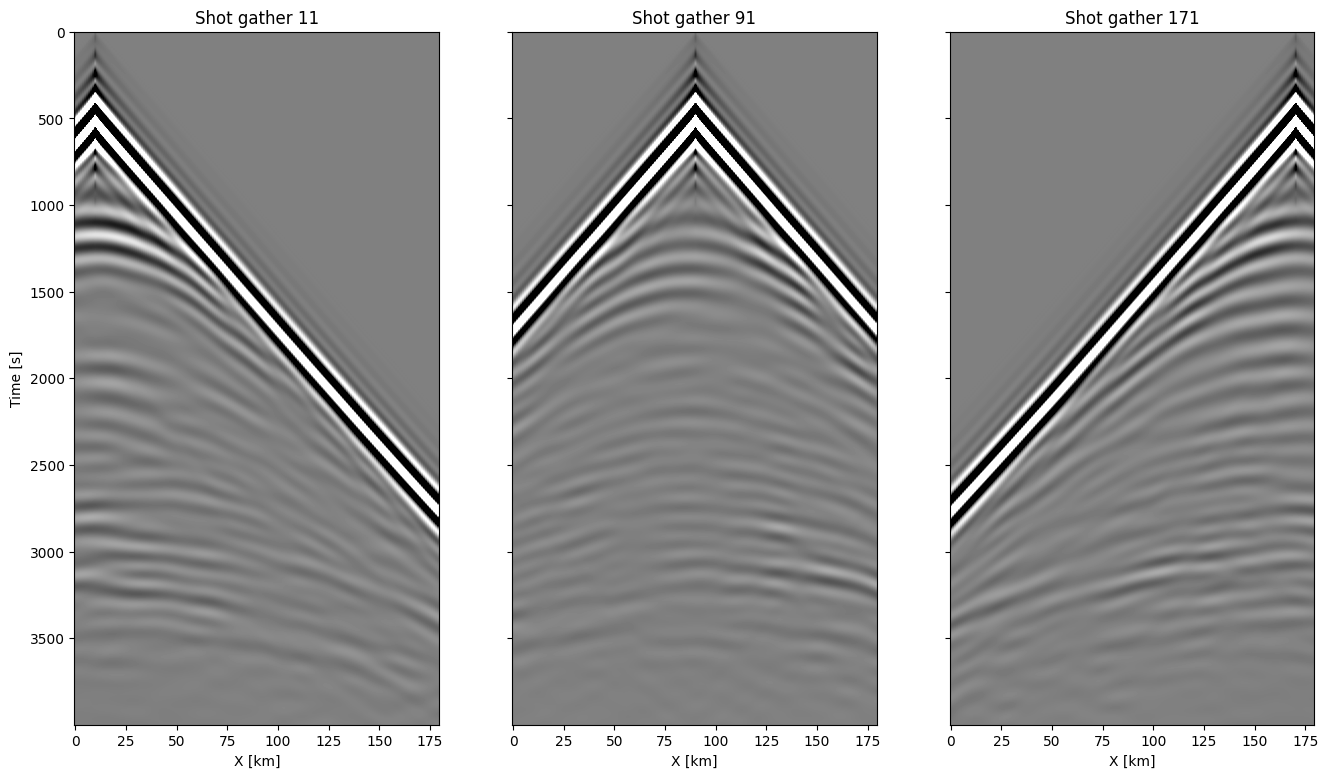

FWI iteration: 59 loss = 1.9530461415748828e-11


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.005341572221368551
Training Epoch 1, Loss = 0.002049520146101713
Training Epoch 2, Loss = 0.0010825305944308639
Training Epoch 3, Loss = 0.0027067107148468494
Training Epoch 4, Loss = 0.003301013493910432
Training Epoch 5, Loss = 0.0018250088905915618
Training Epoch 6, Loss = 0.0007809795788489282
Training Epoch 7, Loss = 0.0012028062483295798
Training Epoch 8, Loss = 0.002059644553810358
Training Epoch 9, Loss = 0.002106025582179427
Training Epoch 10, Loss = 0.0013888536486774683
Training Epoch 11, Loss = 0.0007873470894992352
Training Epoch 12, Loss = 0.0007752581732347608
Training Epoch 13, Loss = 0.0011397319613024592
Training Epoch 14, Loss = 0.0013733962550759315
Training Epoch 15, Loss = 0.001222891383804381
Training Epoch 16, Loss = 0.0008808070560917258
Training Epoch 17, Loss = 0.0006766662118025124
Training Epoch 18, Loss = 0.0007320141885429621
Training Epoch 19, Loss = 0.0009113060659728944
Training Epoch 20, Loss = 0.000995683134533465
Training 

In [26]:
# Run conventional FWI with the Barzilai-Borwein method for a maximum frequency of [4, 7, 10] Hz

# Move model to GPU if using GPU
model_dm = model_init.clone().to(device)
model_dm.requires_grad = True
# Create lists to save results
gradients, dm1s, gradients_pred, dms, updates, fwi_loss, network_loss = [], [], [], [], [], [], []
# Create mask for the shallow part of the gradient
mask = torch.ones_like(model_dm)
mask[:25] = 0
# Create a taper for the gradient
taper = cosine_taper(nz=par['nz'], nx=par['nx'], top_width=100, bottom_width=150)
taper = torch.tensor(taper).float().to(device)
# Create a mask for the direct arrivals
masks_d = params.create_masks(window_size = 600, v_direct = 1800, ot=1000)
masks_d = torch.tensor(masks_d).float().to(device)

loss_fn = nn.MSELoss() # Misfit function for FWI and Born modeling
optimizer = torch.optim.SGD([{'params': [model_dm], 'lr': 1e2,}]) # Optimizer to run FWI with step size: lr
tsamples = 499 # Number of time samples starting from zero to exclude from computing the misfit or shift the data
wav_scaling = 0.0002 # Source wavelet scaling
sigmah, sigmav = 4*2, 10*2 # smoothing parameter for the gradient in the horizontal and vertical direction, respectively
FWI_iter = 60 # Total number of FWI iterations
iterations = [0, 20, 40] # Starting iteration for each frequency, [4, 7, 10] Hz, respectively

l2_norm = nn.MSELoss() # Loss function for the network
network_iter_init = 1000 # Number of epochs to train the network in the first FWI iteration
network_iter_fin = 300 # Number of epochs to train the network in every FWI iteration except the first one

t_start = time.time()
for iteration in tqdm(range(FWI_iter)):
    # Get the wavelet and process the data according to the frequency
    # Also, create the network, its optimizer and the loss function to train it
    if iteration == iterations[0]: # 4 Hz
        wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_4Hz.npz')['wav']
        params = fwi.FWIParams(par, wav_scaling*torch.tensor(wavelet), 'volve')
        observed_data = fwi.process_data(params, rmdd, pd=20, fn=4, time_shift=time_shift,
                                      window_size = 600, v_direct = 1800, more_near_offset_mute=None).to(device)
        network = UNet(n_channels=1, n_classes=1, hidden_channels=64).to(device)
        optimizer_unet = torch.optim.Adam(network.parameters(), lr=1e-4)

    elif iteration == iterations[1]: # 7 Hz
        wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_7Hz.npz')['wav']
        params = fwi.FWIParams(par,wav_scaling*torch.tensor(wavelet), 'volve')
        observed_data = fwi.process_data(params, rmdd, pd=20, fn=7, time_shift=time_shift, 
                                     window_size = 600, v_direct = 1800, more_near_offset_mute=None).to(device)
        # torch.save(network.state_dict(), f'{exp_name}/network_weights_4Hz.pth')
        network = UNet(n_channels=1, n_classes=1, hidden_channels=64).to(device)
        optimizer_unet = torch.optim.Adam(network.parameters(), lr=1e-4)
        sigmah /= 2
        sigmav /= 2
    elif iteration == iterations[2]: # 10 Hz
        wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_10Hz.npz')['wav']
        params = fwi.FWIParams(par,wav_scaling*torch.tensor(wavelet), 'volve')
        observed_data = fwi.process_data(params, rmdd, pd=20, fn=10, time_shift=time_shift, 
                                     window_size = 600, v_direct = 1800, more_near_offset_mute=None).to(device)
        # torch.save(network.state_dict(), f'{exp_name}/network_weights_7Hz.pth')
        network = UNet(n_channels=1, n_classes=1, hidden_channels=64).to(device)
        optimizer_unet = torch.optim.Adam(network.parameters(), lr=1e-4)

    # Save simulated data
    if iteration == FWI_iter - 1:
        data = fwi.forward_modelling(params, model_dm.detach().clone(), device).cpu().numpy()
        show_3_shots(-1*data, [10, 90, 170], clip=0.02, save_path=f'{exp_name}/simulated_data_iter_{iteration}_freq_10_final.png')
        np.savez(f'{exp_name}/simulated_data_iter_{iteration}_freq_10_grad_final', data=data)
    # Compute FWI gradient
    optimizer.zero_grad()
    grad, iter_loss = fwi.compute_gradient(params, model_dm, -observed_data, loss_fn, tsamples, device, masks_d)
    fwi_loss.append(iter_loss)
    print(f'FWI iteration: {iteration} loss = {fwi_loss[-1]}')
    # Clip the gradient values
    torch.nn.utils.clip_grad_value_(model_dm, torch.quantile(grad.detach().abs(), 0.98))
    # Smooth the gradient
    grad[:] = apply_1d_gaussian_filter(grad.detach(), sigmah, sigmav)
    # Apply source illumination to the gradient
    grad = (grad * model_dm.detach().clone()**3 ) / SI
    # Get the maximum of the gradient
    if iteration == iterations[0]: 
        gmax0 =  torch.abs(grad.detach()).max()
    elif iteration == iterations[1]:
        gmax0 =  torch.abs(grad.detach()).max()
    elif iteration == iterations[2]:
        gmax0 =  torch.abs(grad.detach()).max()
    # Normalize the gradient, mask it around the sources and apply tapering to the shallower and deeper parts
    grad = (grad /gmax0) * mask * taper
    gradients.append(grad.cpu().detach().numpy())
    # Compute dm1 with the gradient as the perturbation
    dm1 = grad.detach().clone().float().to(device)
    dm1.requires_grad = True
    dm1 = fwi.compute_dm1(params, model_dm.detach().clone(), dm1 , loss_fn, tsamples, device, masks_d)
    # Apply source illumination to dm1
    dm1 = dm1 * (model_dm.detach().clone() ** 3) / SI
    if iteration == iterations[0]: 
        dm1max0 =  torch.abs(dm1.detach()).max() * 10
    elif iteration == iterations[1]:
        dm1max0 =  torch.abs(dm1.detach()).max() * 10
    elif iteration == iterations[2]:
        dm1max0 =  torch.abs(dm1.detach()).max() * 10
    # Normalize dm1 and mask it around the sources
    dm1 = (dm1 / dm1max0)  * mask
    # Train the network
    training_pair = {'x': dm1.clone().unsqueeze(0).unsqueeze(0),
                    'y': grad.clone().unsqueeze(0).unsqueeze(0)}
    network_iter = network_iter_init if iteration in iterations else network_iter_fin
    lossn = train(network, training_pair, optimizer_unet, l2_norm, network_iter, use_scheduler=True, device=device)
    network_loss.extend(lossn)
    # Get the gradient from the network
    with torch.no_grad():
        g = network(training_pair['x']).squeeze() * mask
    gradients_pred.append(g.cpu().detach().numpy())
    # Get dm from the network
    with torch.no_grad():
        dm = network(training_pair['y']).squeeze() * mask
    dms.append(dm.cpu().detach().numpy())
    model_dm.grad.data[:] = dm.detach().clone()
    optimizer.param_groups[-1]['lr'] = 1e2 if iteration in iterations else 3e1
    # Update the model
    optimizer.step()
    updates.append(model_dm.detach().clone().cpu().numpy())
    # Plot the results
    # show_one_iter_dm(grad.cpu(), dm1.cpu(), g.cpu(), dm.cpu(), model_dm.detach().cpu(), lossn, iteration=iteration,
    #             cmap='bwr', vmin=1000, vmax=5000, extent=(0, 6000, 4500, 0), save_path=f'{exp_name}')
   
t_end = time.time()
t_delta = t_end - t_start
print(f'Runtime:{datetime.timedelta(seconds=t_delta)}')
# Save the results
np.savez(f'{exp_name}/losses', fwi_loss=np.array(fwi_loss),
                               network_loss=np.array(network_loss),
                               )
np.savez(f'{exp_name}/dms', updates=np.array(updates), 
                            gradients=np.array(gradients), 
                            dm1s=np.array(dm1s),
                            gradients_pred=np.array(gradients_pred),
                            dms=np.array(dms),)
torch.save(network.state_dict(), f'{exp_name}/network_weights_10Hz.pth')

In [36]:
loss2 = np.array(fwi_loss)
loss2[:20] /= loss2[1]
loss2[20:40] /= loss2[20]
loss2[40:] /= loss2[41]

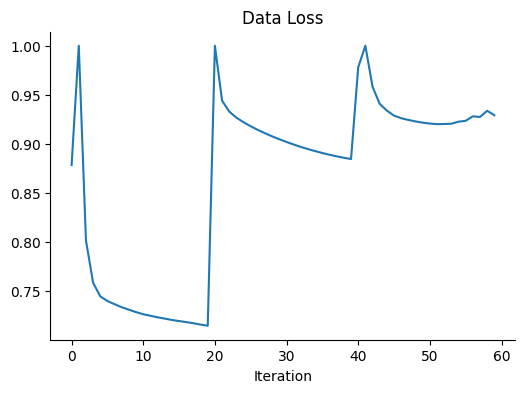

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(loss2)
ax.set_title('Data Loss')
ax.set_xlabel('Iteration')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f'{exp_name}/losses.png',  bbox_inches='tight', dpi=300)